## General Notes
* the Cython/Python wrapper in the following tests about 100-500 ns so is mostly negligible compared to the C function calls
* the ESP32 will use as when compile-time constants and precomputed values as possible
  * e.g. `n_channels`, `n_freq`, `n_time`, and `n_tf` (`=n_freq*n_time`) will all be compile-time constants
  * some values are already made constants (`P` and `Q`) or are precomputed (`freqs_inv` and `freqs_pow_q`)
* in the future, the indexer and length variables should use `int_fast16_t` or `uint_fast16_t` instead of `int` or `size_t`
* all buffers should be annotated with `__attribute__((aligned(16)))` or maybe even `__attribute__((aligned(32)))` to ensure they are aligned optimally
* the timings below are running on ~4 seconds of audio, in reality we will only be processing ~100 ms of audio at a time so expect them to be about 40x faster
  * additionally, the first several functions will only run as "updates" so will be even faster (an update is half the size of the window size, so likely 128-512 samples or ~8-32 ms at 16000 Hz)
* using `float32` instead of `float64` makes a huge difference in speed even on macOS
* the ESP32 has massive benefits to using `float32` over `float64`, according to [this post](https://www.reddit.com/r/esp32/comments/t46960/whats_the_esp32_s3_floating_point_performance/) on the S3:
  * `float32` is ~40x faster than `float64` for addition
  * `float32` is ~100x faster than `float64` for multiplication
    * `float32` multiplication and addition are about the same speed
  * `float32` is ~9x faster than `float64` for division
    * `float32` division is still abysmal (about 1/50th the speed of `float32` multiplication)
    * According to [this article](https://blog.llandsmeer.com/tech/2021/04/08/esp32-s2-fpu.html) and this [issue](https://github.com/espressif/esp-dsp/issues/95) there are ways to make `float32` division much faster
  * `float32` has roughly the same speed as integers for addition and multiplication (but not division)
  * `float32` has special FMA (fused multiply-add) instructions that make it really fast for multiplication and addition together, we should use this whenever possible
* The [ESP-DSP library](https://docs.espressif.com/projects/esp-dsp/en/latest/esp32/esp-dsp-library.html) provides optimized DSP functions for the ESP32 ([github here](https://github.com/espressif/esp-dsp)), the following are of particular interest on the S3:
  * Note: the library is set up so you can include it in a regular C project and it will fall back to regular C functions if the optimized ones are not available
  * `dsps_add_f32`: Add two float32 vectors element-wise: `out[i*step_out] = input1[i*step1] + input2[i*step2]`
    * Also have a super-optimized version for `int16_t`, one for subtraction, and a super-optimized version for `int16_t` subtraction
  * `dsps_addc_f32`: Add a constant to each element of a float32 vector: `out[i*step_out] = input[i*step1] + c`
  * `dsps_mul_f32`: Multiply two float32 vectors element-wise: `out[i*step_out] = input1[i*step1] * input2[i*step2]`
    * Also have a super-optimized version for `int16_t`
  * `dsps_mulc_f32`: Multiply each element of a float32 vector by a constant: `out[i*step_out] = input[i*step1] * c`
  * `dsps_sqrtf_f32` and `dsps_inverted_sqrt_f32`: Compute the approximate square root and inverse square root of a float32 value, however, these are not necessarily faster than calling the regular C functions
  * `dsps_dotprod_f32`: Compute the dot product of two float32 vectors: `out = sum(input1[i*step1] * input2[i*step2])`
    * Also for `int16_t` and ones with steps
  * `dsps_memcpy` and `dsps_memset`: Copy and set memory, these are optimized for the ESP32-S3
  * Several matrix operations
  * Several filters (IIR, FIR, and convolution)
  * FFTs

## Summary

### Converted to C
* Decimation (e.g. converting from 44.1 kHz to 16 kHz): 283 µs / 40 => 7.075 µs  (int16 version is 573 µs / 40 => 14.325 µs)
  * Updatable
  * Depending on the parameters for decimation, there are sometimes huge differences between scipy and the ESP32 results
* Normalize data: 9.05 µs / 40 => 0.23 µs
  * Updatable
* Rolling all data to prepare for new data: ~4 µs
* Construct spectrogram: 1.1 ms / 40 => 35 µs
  * NOTE: Have a "transposed" version that outputs time by frequency; it runs ~40% faster but nearly all other functions would need to be updated to use transposed data (which may slow them down, but seeing that this is the longest function so far, it may be worth it)
    * One major disadvantage is that on update runs having time in the last dimension really helps with simplicity and speed
  * Updatable
* Compute attenuation and delay: 510 µs / 40 => 12.75 µs
  * Transposed version is the same speed and has simpler code
  * Updatable
* Compute weights: 17 µs / 40 => 0.43 µs
  * Transposed version is the same speed and has simpler code
  * Updatable
* Find Peaks (MS): very slow, but getting faster
  * Not updatable
* Convert symmetric to asymmetric attenuation: 0.17 µs - Cython overhead
* Compute sources: 807 µs / 40 => 20.175 µs  (4 sources)
  * Not updatable
  * Final version will likely use a combined compute sources + demix function that eliminates many computations (maybe ~1/6)
* Demix: 73 µs / 40 => 1.825 µs
  * Transposed version is barely slower and has barely more complex code
  * Not updatable
* Convert to time domain: <mark>TODO</mark>

Total (so far): 7.075 + 0.23 + 35 + 12.75 + 0.43 + ? + 0.17 + 20.175 + 1.825 + ? = 80.6 µs for ~96 ms  
Updates (~1/6): 0.6 + 0.02 + 6 + 3 + 2 + 0.1 + ? + 0.17 + 20.175 + 1.825 + ? = 33.9 µs for ~8 ms  

### Precompute
The following are computed once at the start of the program and then used in the above functions:
* `decimate_init`: 0.4 µs - Cython overhead
* `sftf_init`: 1.4 µs - Cython overhead
* `hamming_window`: 1.1 µs - Cython overhead
* `dual_window`: 0.5 µs - Cython overhead
* `freqs`: 0.4 µs - Cython overhead
* `freqs_inv`: 0.4 µs - Cython overhead
* `freqs_pow_q`: 0.4 µs - Cython overhead

Total (so far): 0.4 + 1.4 + 1.1 + 0.5 + 0.4 + 0.4 + 0.4 = 4.6 µs for a window size of 256

In [1]:
# Disable any multi-threading in numpy and scipy to avoid issues comparisons
# The ESP32 will effectively run single-threaded (it has 2 cores, but one will be used for all of the data management)
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'

In [2]:
import numpy as np
import scipy as sp
from numpy import ndarray, nan

import cython

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

from IPython.display import display, Audio

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext cython

In [4]:
from duet_ms import DuetMS
#from duet_orig import DuetOrig
from mean_shift import *

In [5]:
fs, x_orig = sp.io.wavfile.read('x.wav')  # 'rendered_audio/tp_-60_cough_+30.wav'  #'binaural_simulated.wav'
x_orig = x_orig.T
x_orig = x_orig[:, :fs*5]  # at most 5 seconds
if fs != 16000:
    x = sp.signal.resample(x_orig, 16000 * x_orig.shape[1] // fs, axis=1)
    fs = 16000
else:
    x = x_orig
if x.shape[1] % 128 != 0:
    x = x[:, :x.shape[1] - (x.shape[1] % 128)]  # make it a multiple of 128

#x = x[:, :16384]

display(Audio(x, rate=fs))

In [6]:
# Convert frequency to 48 kHz
x_48 = sp.signal.resample(x_orig, 48000 * x_orig.shape[1] // fs, axis=1).round().astype(np.int16)
# Take first 96+8 ms
x_48 = x_48[:, :48*(96+8)]
# Break into 8 ms chunks
x_48 = x_48.reshape((2, -1, 384))
interleaved = np.empty((2*x_48.shape[2],), dtype=np.int16)
print(f"const int16_t audio_data[{x_48.shape[1]}][{x_48.shape[2]*2}] = {{")
for i in range(x_48.shape[1]):
    interleaved[0::2] = x_48[0, i]
    interleaved[1::2] = x_48[1, i]
    print(f"  {{ {', '.join([hex(c) for c in interleaved])} }},")
print("};")

const int16_t audio_data[13][768] = {
  { 0x7b, 0xb7, 0x105, 0xb3, 0x1c0, 0xae, 0x27e, 0xbd, 0x317, 0xf6, 0x379, 0x162, 0x3a7, 0x1fa, 0x3aa, 0x2ad, 0x387, 0x364, 0x33b, 0x406, 0x2c6, 0x480, 0x235, 0x4c5, 0x19f, 0x4d2, 0x121, 0x4ab, 0xd4, 0x459, 0xc7, 0x3e5, 0x106, 0x357, 0x194, 0x2b8, 0x26c, 0x21e, 0x370, 0x1a9, 0x470, 0x182, 0x531, 0x1c7, 0x583, 0x27a, 0x556, 0x37a, 0x4bc, 0x48f, 0x3df, 0x579, 0x2ec, 0x609, 0x207, 0x627, 0x145, 0x5d4, 0xb0, 0x520, 0x53, 0x41f, 0x34, 0x2ef, 0x53, 0x1b5, 0xa8, 0x9b, 0x11f, -0x32, 0x19e, -0x93, 0x210, -0x7a, 0x267, 0xd, 0x29e, 0xe4, 0x2bb, 0x1e0, 0x2c5, 0x2d0, 0x2c4, 0x38b, 0x2b9, 0x3f5, 0x2a1, 0x408, 0x274, 0x3d5, 0x22b, 0x37e, 0x1c9, 0x326, 0x15a, 0x2e8, 0xf3, 0x2c8, 0xa7, 0x2bb, 0x85, 0x2ac, 0x90, 0x287, 0xc4, 0x246, 0x118, 0x1f0, 0x17e, 0x19c, 0x1ec, 0x166, 0x25a, 0x166, 0x2c2, 0x1ab, 0x323, 0x22e, 0x37b, 0x2db, 0x3c2, 0x395, 0x3e4, 0x441, 0x3c9, 0x4d2, 0x35d, 0x544, 0x2a2, 0x595, 0x1b5, 0x5be, 0xc7, 0x5af, 0x10, 0x554, -0x4a, 0x4a2, -0x3b, 0x3a1, 0x

In [8]:
duet = DuetMS(fs, threshold=0.5, attenuation_max=3.6, delay_max=3.6)
#duet_orig = DuetOrig(fs)

xx = duet._normalize_data(x)
tf = duet._construct_spectrogram(xx)  # 17%
alpha, delta = duet._compute_attenuation_and_delay(tf)  # 1%
tf_weights = duet._compute_weights(tf)


points, weights = duet._get_points(tf_weights, alpha, delta)  # 0.7%
seeds = get_seeds(points, duet.bandwidth, duet.min_bin_count, duet.seed_count, duet._bounds(1))  # 0.7%
if seeds.size == 0: raise ValueError("no seeds found")
kernel = make_gaussian_kernel(duet.bandwidth, weights)
centroids = mean_shift(points, kernel, seeds, np.min(duet.bandwidth), convergence_tol=duet.convergence_tol)  # 37%
sym_atn_peaks, delay_peaks = centroids[:, 0], centroids[:, 1]


atn_peaks = duet._convert_sym_to_atn(sym_atn_peaks)
best, sources = duet._compute_sources(tf, atn_peaks, delay_peaks)
demixed = duet._demix(best, sources)
est = duet._convert_to_time_domain(demixed)[:, :xx.shape[-1]]  # 21%

In [8]:
(duet.stft.hop,  # number of samples put into a single time index of the spectrogram
 duet.stft.hop/fs)  # seconds per time index

(128, 0.008)

In [9]:
x.shape, tf.shape, tf.dtype

((2, 65408), (2, 128, 512), dtype('complex128'))

## Roll Data

In [99]:
%%cython -c=-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION -c=-O3 -c=-ffast-math
cimport numpy as np
import numpy as np

cdef extern from *:
    """
    /**
     * Roll the last axis of the data to the left by the length of the new data and
     * concatenate the new data to the end of the data. Modifies the data in place.
     */
    // This function matches the description of `_roll` but the other function
    // actually matches the description of `_roll`.
    static void c_roll(
        uint8_t* data,                 // in/out, shape of (shape, data_len)
        int shape, int data_len,
        const uint8_t* const new_data, // in, shape of (shape, new_len)
        int new_len
    ) {
        for (int i = 0; i < shape; i++) {
            uint8_t* a = &data[i*data_len];
            uint8_t* b = &a[new_len];
            uint8_t* c = &a[data_len-new_len];
            const uint8_t* const d = &new_data[i*new_len];
            memmove(a, b, data_len-new_len);  // TODO: use dsps_memcpy?
            memmove(c, d, new_len);           // TODO: use dsps_memcpy
        }
    }

    /**
     * Same as c_roll, but the last bit of the old data is overwritten by the first
     * element of the new data. If `overwrite_len` is 0, this is equivalent to c_roll.
     */
    // This function matches the behavior of `_roll` even though it doesn't mention
    // the overwrite behavior in the docstring.
    static void c_roll_overwrite(
        uint8_t* data,                 // in/out, shape of (shape, data_len)
        int shape, int data_len, int overwrite_len,
        const uint8_t* const new_data, // in, shape of (shape, new_len)
        int new_len
    ) {
        for (int i = 0; i < shape; i++) {
            uint8_t* a = &data[i*data_len];
            uint8_t* b = &a[new_len-overwrite_len];
            uint8_t* c = &a[data_len-new_len];
            const uint8_t* const d = &new_data[i*new_len];
            memmove(a, b, data_len-new_len);  // TODO: use dsps_memcpy?
            memmove(c, d, new_len);           // TODO: use dsps_memcpy
        }
    }

    /**
     * Same as c_roll, but the new data is left as garbage.
     */
    static void c_roll_contents(
        uint8_t* data,                 // in/out, shape of (shape, data_len)
        int shape, int data_len, int overwrite_len, int new_len
    ) {
        for (int i = 0; i < shape; i++) {
            uint8_t* a = &data[i*data_len];
            memmove(a, &a[new_len-overwrite_len], data_len-new_len);  // TODO: use dsps_memcpy?
        }
    }

    """
    void c_roll(
        np.uint8_t* data,                 # in/out, shape of (shape, data_len)
        int shape, int data_len,
        const np.uint8_t* const new_data, # in, shape of (shape, new_len)
        int new_len
    ) nogil
    void c_roll_overwrite(
        np.uint8_t* data,                 # in/out, shape of (shape, data_len)
        int shape, int data_len, int overwrite_len,
        const np.uint8_t* const new_data, # in, shape of (shape, new_len)
        int new_len
    ) nogil
    void c_roll_contents(
        np.uint8_t* data,                 # in/out, shape of (shape, data_len)
        int shape, int data_len, int overwrite_len, int new_len
    ) nogil

def cy_roll(np.ndarray data, np.ndarray new):
    # assumes data and new have the same shape except for the last dimension and same dtype
    cdef int data_len = data.shape[data.ndim-1], new_len = new.shape[new.ndim-1]
    cdef int shape = data.size // data_len
    cdef int itemsize = data.itemsize
    with nogil:
        c_roll(
            <np.uint8_t*>data.data,
            shape, data_len*itemsize,
            <np.uint8_t*>new.data,
            new_len*itemsize
        )

def cy_roll_overwrite(np.ndarray data, np.ndarray new, int overwrite_len=1):
    # assumes data and new have the same shape except for the last dimension and same dtype
    cdef int data_len = data.shape[data.ndim-1], new_len = new.shape[new.ndim-1]
    cdef int shape = data.size // data_len
    cdef int itemsize = data.itemsize
    with nogil:
        c_roll_overwrite(
            <np.uint8_t*>data.data,
            shape, data_len*itemsize, overwrite_len*itemsize,
            <np.uint8_t*>new.data,
            new_len*itemsize
        )

def cy_roll_contents(np.ndarray data, int new_len, int overwrite_len=0):
    cdef int data_len = data.shape[data.ndim-1], shape = data.size // data_len, itemsize = data.itemsize
    with nogil:
        c_roll_contents(<np.uint8_t*>data.data, shape, data_len*itemsize, overwrite_len*itemsize, new_len*itemsize)

Content of stderr:
/Users/bushj/.cache/ipython/cython/_cython_magic_c867ae02764cfe8a0d4b706df168b014029c3787.c:6829:26: warning: code will never be executed [-Wunreachable-code]
 6829 |                 module = PyImport_ImportModuleLevelObject(
      |                          ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1 warning generated.
/Users/bushj/.cache/ipython/cython/_cython_magic_c867ae02764cfe8a0d4b706df168b014029c3787.c:6829:26: warning: code will never be executed [-Wunreachable-code]
 6829 |                 module = PyImport_ImportModuleLevelObject(
      |                          ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1 warning generated.

In [100]:
from duet_base import _roll
x = np.random.random((4, 5)).astype(np.float32)
x_orig = x.copy()
y = np.random.random((4, 1)).astype(np.float32)
z = _roll(x, y)
cy_roll_overwrite(x, y)
z == x

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

In [ ]:
# We need to roll:
#  - audio:   float (n_channels, window_size??)
#  - TF/spectrogram: complex (n_channels, n_freq, n_time)
#  - alpha:   float (n_freq, n_time)
#  - delta:   float (n_freq, n_time)
#  - weights: float (n_freq, n_time)
# We roll by 1 and overwrite 1 (since the most recent data was computed with zero-padding)

x = np.random.random((2, 128, 12)).astype(np.complex64)
y = np.random.random((2, 128, 2)).astype(np.complex64)
%timeit _roll(x, y)
%timeit cy_roll_overwrite(x, y, 1)
%timeit cy_roll_contents(x, 2, 1)

print()

x = np.random.random((128, 12)).astype(np.float32)
y = np.random.random((128, 2)).astype(np.float32)
%timeit _roll(x, y)
%timeit cy_roll_overwrite(x, y, 1)
%timeit cy_roll_contents(x, 2, 1)

3.53 µs ± 836 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
1.69 µs ± 85.5 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
725 ns ± 61.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)

2.46 µs ± 702 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
1.13 µs ± 265 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
679 ns ± 74.5 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


## Decimation

In [10]:
%%cython -c=-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION -c=-O3 -c=-ffast-math -Iesp-dsp-master/modules/common/include -Iesp-dsp-master/modules/common/include_sim -Iesp-dsp-master/modules/support/include -Iesp-dsp-master/modules/windows/blackman/include -Iesp-dsp-master/modules/fir/include -Sesp-dsp-master/modules/common/misc/dsps_pwroftwo.cpp -Sesp-dsp-master/modules/fir/float/dsps_fir_f32_ansi.c -Sesp-dsp-master/modules/fir/float/dsps_fird_f32_ansi.c -Sesp-dsp-master/modules/fir/float/dsps_fird_init_f32.c -Sesp-dsp-master/modules/fir/float/dsps_fir_init_f32.c -Sesp-dsp-master/modules/fir/fixed/dsps_fird_s16_ansi.c -Sesp-dsp-master/modules/fir/fixed/dsps_fird_init_s16.c -Sesp-dsp-master/modules/windows/blackman/float/dsps_wind_blackman_f32.c
cimport numpy as np
import numpy as np
from cpython.mem cimport PyMem_Malloc, PyMem_Free
from libc.stdint cimport int16_t
from libc.string cimport memcpy

cdef extern from "dsps_fir.h":
    struct fir_f32_s:
        float  *coeffs
        float  *delay
        int     N
        int     pos
        int     decim
        int16_t use_delay
    ctypedef fir_f32_s fir_f32_t
    struct fir_s16_s: pass
    ctypedef fir_s16_s fir_s16_t

cdef extern from *:
    """
    #include <stdbool.h>
    #include <stdint.h>
    #include <math.h>
    #include <dsps_wind_blackman.h>

    static void dsps_wind_hamming_f32(float* window, int len) {
        float factor = 2 * M_PI / (float)(len - 1);
        for (int i = 0; i < len; i++) { window[i] = 0.54f - 0.46f * cosf(i * factor); }
    }
    static void compute_fir_coeffs(
        float* coeffs, // output, has length fir_len
        int fir_len,   // length of the FIR filter
        float cutoff   // cutoff frequency (normalized, 0 to 1)
    ) {
        const float cutoff_pi = M_PI * cutoff, halfway = (fir_len - 1) * 0.5f;
        float window[fir_len];
        dsps_wind_hamming_f32(window, fir_len);
        float sum = 0.0f;
        for (int i = 0; i < fir_len; i++) {
            float c = 1.0f;
            if (i != halfway) {
                c = cutoff_pi * (i - halfway);
                c = sinf(c) / c; // TODO: use DIVIDE(...)
            }
            c *= window[i] * cutoff;
            coeffs[i] = c;
            sum += c;
        }
        for (int i = 0; i < fir_len; i++) { coeffs[i] /= sum; }
    }

    static int init_decimate(
        fir_f32_t* fir,
        int decimation, // decimation factor // TODO: make a compile-time constant
        int fir_len     // length of the FIR filter // TODO: make a compile-time constant
    ) {
        // dsps_fird_init_f32 on ESP32-S3 requires:
        //    a multiple of 4 fir length (pad with zeros if necessary)
        //    coeffs and delay line must be aligned to 16 bytes: memalign(16, nbytes) or __attribute__((aligned(16))) for global variables
        const int fir_len_4 = (fir_len + 3) & ~3;  // round up to the nearest multiple of 4 and zero-pad
        float* coeffs = malloc(fir_len_4 * sizeof(float)); // TODO: memalign(16, ...);
        float* delay = malloc(fir_len_4 * sizeof(float)); // TODO: memalign(16, ...);
        if (coeffs == NULL || delay == NULL) { free(coeffs); free(delay); return -1; } // TODO: return ESP_ERR_NO_MEM
        compute_fir_coeffs(coeffs, fir_len, 1.0f / decimation);  // TODO: use recip(...)
        for (int i = fir_len; i < fir_len_4; i++) { coeffs[i] = 0.0f; }
        return dsps_fird_init_f32(fir, coeffs, delay, fir_len_4, decimation);
    }
    static void deinit_decimate(fir_f32_t* fir) {
        if (fir) {
            free(fir->coeffs); fir->coeffs = NULL;
            free(fir->delay); fir->delay = NULL;
        }
    }
    static int decimate(
        fir_f32_t* fir,
        const float *input, // has length len + fir_len/decimation?
        float *output, // has length len / decimation
        int len
    ) { return dsps_fird_f32(fir, input, output, len / fir->decim); }

    """
    int init_decimate(
        fir_f32_t* fir,
        int decimation,  # decimation factor
        int fir_len      # length of the FIR filter
    ) nogil
    int deinit_decimate(fir_f32_t* fir) nogil
    int decimate(
        fir_f32_t* fir,
        const float *input,  # has length len + fir_len/decimation
        float *output,       # has length len / decimation
        int len
    ) nogil

cdef class FirF32Handle:
    cdef fir_f32_t* fir

    def __cinit__(self, int decimation, int fir_len):
        # allocate some memory (uninitialised, may contain arbitrary data)
        self.fir = <fir_f32_t*>PyMem_Malloc(sizeof(fir_f32_t))
        if not self.fir: raise MemoryError()
        err = init_decimate(self.fir, decimation, fir_len)
        if err != 0:
            PyMem_Free(self.fir)
            self.fir = NULL
            raise RuntimeError("Failed to initialize FIR filter")

    def delay_line(self):
        cdef np.ndarray[np.float32_t, ndim=1, mode='c'] delay = np.empty(self.fir.N, dtype=np.float32)
        memcpy(<np.uint8_t*>delay.data, <np.uint8_t*>self.fir.delay, self.fir.N * sizeof(float))
        return delay

    def delay_line_pos(self):
        return self.fir.pos

    def __dealloc__(self):
        deinit_decimate(self.fir)
        PyMem_Free(self.fir)  # no-op if self.fir is NULL
        self.fir = NULL

def cy_init_decimate(
    int decimation,  # decimation factor
    int fir_len      # length of the FIR filter
): return FirF32Handle(decimation, fir_len)

def cy_decimate(
    FirF32Handle fir,
    np.ndarray[np.float32_t, ndim=1, mode='c'] input,
    np.ndarray[np.float32_t, ndim=1, mode='c'] output,
):
    cdef int length = input.shape[0]
    cdef float *input_ptr = <float *>input.data
    cdef float *output_ptr = <float *>output.data
    return decimate(fir.fir, input_ptr, output_ptr, length)


In [11]:
decimation = 2
order = 39  # one less than the length of the FIR filter
fir_length = order + 1  # length of the FIR filter
delay_pre = (fir_length - 1) // 2  # Note: when order+1 is not a multiple of 4 this is a bit wrong (multiple-of-4+1 adds 2 to the delay; +2 and +3 are not integer delays)
delay = delay_pre // decimation
fir = cy_init_decimate(decimation, order+1)

length = 65448

y = np.arange(0, length)
cy_x = np.ascontiguousarray(x_orig[0, :length] / 32768.0, dtype=np.float32)
x_dec = sp.signal.decimate(cy_x, decimation, n=order, ftype='fir', zero_phase=True)
cy_out = np.zeros(length//decimation + delay, dtype=np.float32)
count = cy_decimate(fir, np.concatenate([cy_x, np.zeros(delay_pre, np.float32)]), cy_out)
cy_out = cy_out[:count]
count

32733

(1.4901161e-07, 5.497367e-09, False)

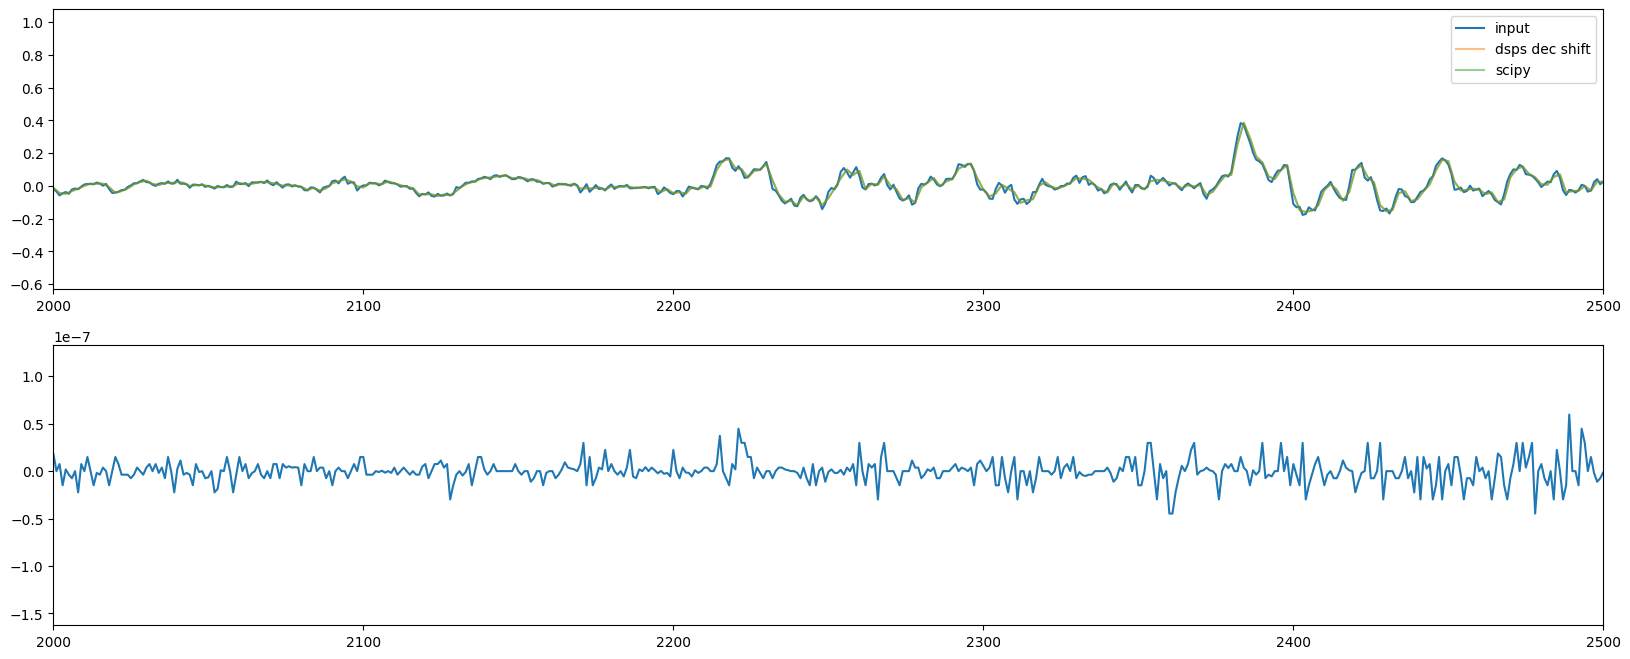

In [12]:
plt.figure(figsize=(20, 8))

plt.subplot(2, 1, 1)
plt.plot(y, cy_x, label='input')
plt.plot(y[::decimation], cy_out[delay:], label='dsps dec shift', alpha=0.5)
plt.plot(y[::decimation], x_dec, label='scipy', alpha=0.5)
plt.legend()
plt.xlim(2000, 2500)

plt.subplot(2, 1, 2)
diff = cy_out[delay:] - x_dec[:]
plt.plot(diff)
plt.xlim(2000, 2500)
abs(diff).max(), abs(diff).mean(), np.allclose(cy_out[delay+1:], x_dec[:-1], atol=1e-6)

In [13]:
cy_x = np.ascontiguousarray(x_orig[0, :length] / 32768.0, dtype=np.float32)

fir = cy_init_decimate(decimation, order+1)

chunk_size = 256
cy_out = np.zeros(length//decimation + delay, dtype=np.float32)

count = 0
for i in range(0, length, chunk_size):
    end = min(i + chunk_size, length)
    count += cy_decimate(fir, cy_x[i:end], cy_out[count:count+length//decimation])
cy_out = cy_out[delay:count]

(1.4901161e-07, 5.498851e-09, True)

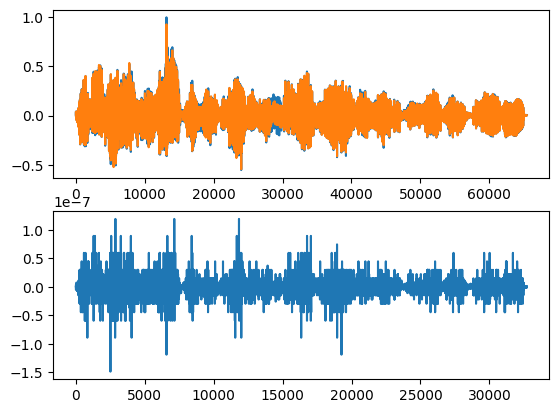

In [14]:
plt.subplot(2, 1, 1)
plt.plot(y[:count*2], cy_x[:count*2])
plt.plot(y[:count*2-delay*decimation:decimation], cy_out)

plt.subplot(2, 1, 2)
diff = cy_out - x_dec[:-delay]
plt.plot(diff)
abs(diff).max(), abs(diff).mean(), np.allclose(cy_out, x_dec[:-delay], atol=1e-6)

In [402]:
%timeit cy_init_decimate(decimation, order+1)
%timeit sp.signal.decimate(cy_x, decimation, n=order, ftype='fir', zero_phase=True)
%timeit cy_decimate(fir, cy_x, cy_out)

404 ns ± 55.2 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
767 µs ± 5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
304 µs ± 55.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


(-10.0, 10.0)

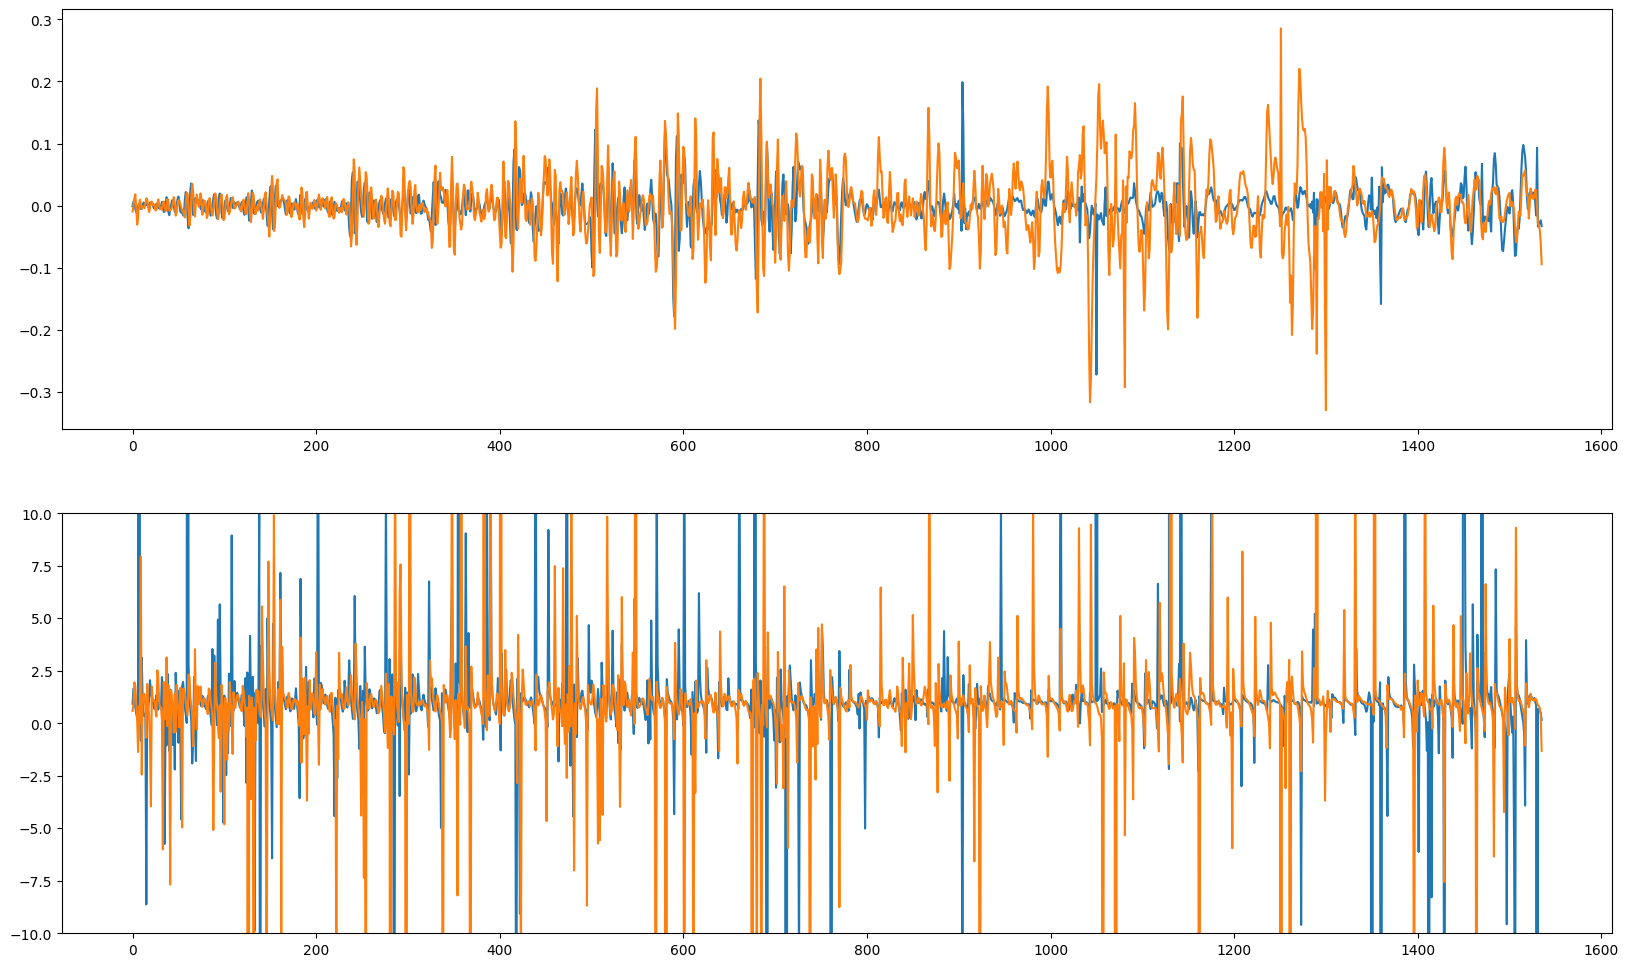

In [43]:
# TODO: decimate on the ESP32 has some significant differences compared to scipy, even when trying to take into account the delay
from duet_0000.dump_0012 import audio_dump
x_48_ = (x_48.reshape(2, -1) / 32768.0).astype(np.float32)
x_48_dec = sp.signal.decimate(x_48_, 3, n=59, ftype='fir', zero_phase=True)
plt.figure(figsize=(20, 12))
plt.subplot(2, 1, 1)
plt.plot(x_48_dec[:, 120:120 + audio_dump.shape[1]].T - audio_dump.T)
plt.subplot(2, 1, 2)
plt.plot(x_48_dec[:, 120:120 + audio_dump.shape[1]].T / audio_dump.T)
plt.ylim(-10, 10)

## Normalize Data

In [44]:
%%cython -c=-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION -c=-O3 -c=-ffast-math
cimport numpy as np
import numpy as np
from libc.stdint cimport int16_t

cdef extern from *:
    """
    #include <stdint.h>
    static void c_normalize(const int16_t * const x, const int n, float* xx) {
        float scale = 1.0 / 32767.0f;  // TODO: or 32768?
        for (int i = 0; i < n; i++) { xx[i] = x[i] * scale; }
    }

    // update version of c_normalize
    // assumes that xx is already rolled
    // x contains all of the new data
    /*static void c_normalize_update(
        const int16_t * const x,    // in, shape of (shape, x_len)
        const int shape, const int x_len,
        float* xx,                  // out, shape of (shape, xx_len)
        const int xx_len
    ) {
        xx += xx_len-x_len;  // shift the output pointer to the end of the rows
        for (int i = 0; i < shape; i++) {
            c_normalize(
                x + i*x_len,   // source row
                x_len,         // amount of new data
                xx + i*xx_len  // destination row
            );
        }
    }
    // update version of c_normalize
    // assumes that xx is already rolled
    // x contains a mix of old and new data (equivalent to c_normalize_update if x_len == update_len)
    static void c_normalize_update_2(
        int16_t * const x,  // in, shape of (shape, x_len)
        const int shape, const int x_len,
        float* xx,          // out, shape of (shape, xx_len)
        const int xx_len, const int update_len
    ) {
        x += x_len-update_len;  // shift the input pointer to the end of the rows
        xx += xx_len-update_len;  // shift the output pointer to the end of the rows
        for (int i = 0; i < shape; i++) {
            c_normalize(
                x + i*x_len,   // source row
                update_len,    // amount of new data
                xx + i*xx_len  // destination row
            );
        }
    }*/
    """
    void c_normalize(
        int16_t * x, # in, length of n
        int n,
        float * xx   # out, length of n
    ) nogil

def cy_normalize(
    np.ndarray[np.int16_t, ndim=2, mode='c'] np_x,
    np.ndarray[np.float32_t, ndim=2, mode='c'] np_xx
):
    cdef int n_channels = np_x.shape[0]
    cdef int n_samples = np_x.shape[1]
    cdef np.int16_t* x = &np_x[0, 0]
    cdef np.float32_t* xx = &np_xx[0, 0]
    with nogil: c_normalize(x, n_channels*n_samples, xx)


In [11]:
cy_x = np.ascontiguousarray(x)
cy_xx = np.empty(cy_x.shape, np.float32)
cy_normalize(cy_x, cy_xx)
np.allclose(cy_xx, xx)

True

In [628]:
%timeit x / 32767.0
%timeit cy_normalize(cy_x, cy_xx)

72.4 µs ± 7.6 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
10.6 µs ± 719 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [13]:
from dumps import audio_dump
np.allclose(audio_dump, xx[:, :1536])

True

## Construct Spectrogram and Convert to Time Domain

In [45]:
%%cython -c=-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION -c=-O3 -c=-ffast-math -Iesp-dsp-master/modules/common/include -Iesp-dsp-master/modules/common/include_sim -Iesp-dsp-master/modules/fft/include -Iesp-dsp-master/modules/support/include -Sesp-dsp-master/modules/common/misc/dsps_pwroftwo.cpp -Sesp-dsp-master/modules/fft/float/dsps_fft4r_fc32_ansi.c -Sesp-dsp-master/modules/fft/float/dsps_fft4r_bitrev_tables_fc32.c -Sesp-dsp-master/modules/fft/float/dsps_fft2r_fc32_ansi.c -Sesp-dsp-master/modules/fft/float/dsps_fft2r_bitrev_tables_fc32.c
cimport numpy as np
import numpy as np

from libc.string cimport memcpy, memset
from libc.math cimport log10 as log10f, sqrt as sqrtf

# This uses the radix-2 or radix-4 FFT algorithm from the eSP32 DSP library.
# This means that the input data (in number of reals) must be two times a power of 2 or 4 (powers of 4: 4, 16, 64, 256, 1024, 4096)
# The max FFT size for either is 8192 reals (or 4096 complex samples)
# Radix-2 is about 60% slower for size = 2048 reals
# For STFT this is the window size, which we will likely make between 256 and 1024 samples
#    Maybe we should use one of 128, 512, or 2048 since those can use the radix-4 FFT

cdef extern from "dsps_fft4r.h":
    # For all of these functions, `max_fft_size` or `N` is the number of complex samples (if this is for real samples, half N)
    # init: even when provided with a non-NULL buffer, part of it is still allocated internally/globally, may as well just always use NULL...
    int dsps_fft4r_init_fc32(float* fft_table_buff, int max_fft_size) nogil
    int dsps_fft4r_deinit_fc32() nogil
    int dsps_fft4r_fc32(float *data, int N) nogil
    int dsps_bit_rev4r_fc32(float *data, int N) nogil
    int dsps_cplx2real_fc32(float *data, int N) nogil

cdef extern from "dsps_fft2r.h":
    int dsps_fft2r_init_fc32(float* fft_table_buff, int max_fft_size) nogil
    int dsps_fft2r_deinit_fc32() nogil
    int dsps_fft2r_fc32(float *data, int N) nogil
    int dsps_bit_rev2r_fc32(float *data, int N) nogil

cdef extern from "dsp_common.h":
    bint dsp_is_power_of_two(int x) nogil
    int dsp_power_of_two(int x) nogil

cdef extern from *:
    """
    #include <stdbool.h>

    // ESP-DSP library provides the Hann window function, similar but different from the Hamming window
    static void dsps_wind_hamming_f32(float* window, int len) {
        float factor = 2 * M_PI / (float)(len - 1);
        for (int i = 0; i < len; i++) { window[i] = 0.54f - 0.46f * cosf(i * factor); }
    }
    static void dsps_wind_dual(float* win, float* out, int len) {
        // assumes the window is symmetrical
        int hop = len / 2;
        for (int i = 0; i < hop; i++) { out[i] = win[i] / (win[i] * win[i] + win[i+hop] * win[i+hop]); }
        out[hop] = win[hop] / (win[hop] * win[hop] + win[0] * win[0]);
        for (int i = hop; i < len; i++) { out[i] = out[len-i-1]; }
    }

    // same as scipy's STFT.f value
    static void c_frequencies_raw(float* freqs, int n, int fs) {
        int n_2 = (n >> 1) + 1;  // since this is for real samples, we only need half the frequencies
        float factor = fs / (float)n;
        for (int i = 0; i < n_2; i++) { freqs[i] = i * factor; }
    }
    // scaled version used in this code (no longer dependent on fs and skips the DC frequency)
    static void c_frequencies(float* freqs, int n) {
        int n_2 = (n >> 1);  // since this is for real samples, we only need half the frequencies
        float factor = 2 * M_PI / n;
        for (int i = 0; i < n_2; i++) { freqs[i] = (i + 1) * factor; }
    }

    static bool is_power_of_four_given_is_pow_2(int n) { return (n & 0xAAAAAAAA) == 0; }  // assuming n is a power of 2, checks if it is also a power of 4
    //static bool is_power_of_four(int n) { return dsp_is_power_of_two(n) && is_power_of_four_given_is_pow_2(n); }

    // n complex numbers as pairs of floats (real, imag); operates in-place
    static void arr_conj(float* x, int n) { for (int i = 0; i < n; i++) { x[2*i+1] = -x[2*i+1]; } } // TODO: maybe use dsps_mulc_f32(x+1, x+1, n, -1f, 2, 2)

    static void compute_stft_first_window(const float* const x, const float* const window, const int ws_2, float* out) {
        memset(out-ws_2, 0, ws_2 * sizeof(float));
        for (int k = 0; k < ws_2; k++) { out[k] = x[k] * window[k]; }
    }
    static void compute_stft_last_window(const float* const x, const float* const window, const int ws_2, float* out) {
        for (int k = -ws_2; k < 0; k++) { out[k] = x[k] * window[k]; }
        memset(out, 0, ws_2 * sizeof(float));
    }
    static void compute_stft_mid_window(const float* const x, const float* const window, const int ws_2, float* out) {
        for (int k = -ws_2; k < ws_2; k++) { out[k] = x[k] * window[k]; }
    }

    /**
     * Copy the result of the complex FFT to the output of the complex STFT.
     * This does not copy the DC component. This assumes that the first complex element
     * in the FFT data is actually the real part of the DC frequency and the real part
     * of the last frequency.
     */
    static void copy_fft_to_stft_out(float* fft, int n_freq, int n_time, float* out) {
        for (int k = 1; k < n_freq; k++) {
            out[(k-1)*n_time*2] = fft[2*k];
            out[(k-1)*n_time*2 + 1] = fft[2*k+1];
        }
        // k == n_freq - 1 comes from the second element of the FFT data
        out[(n_freq-1)*n_time*2] = fft[1];
        out[(n_freq-1)*n_time*2 + 1] = 0;
    }

    // This is the transposed version of the above function: output is time by frequency
    static void copy_fft_to_stft_out_trans(float* fft, int n_freq, float* out) {
        memcpy(out, fft+2, (n_freq-1) * 2 * sizeof(float));               // TODO: use dsps_memcpy(...)
        // k == n_freq - 1 comes from the second element of the FFT data
        out[(n_freq-1)*2] = fft[1];
        out[(n_freq-1)*2 + 1] = 0;
    }

    static void fft_core(
        float* x,  // in/out, shape n complex numbers (2*n floats)
        const int n, const bool use_radix4  // eventually this will be a compile-time constant
    ) {
        if (use_radix4) {
            dsps_fft4r_fc32(x, n);
            dsps_bit_rev4r_fc32(x, n);
        } else {
            dsps_fft2r_fc32(x, n);
            dsps_bit_rev2r_fc32(x, n);
        }
    }

    static void rfft(
        float* x,  // in/out, shape n complex numbers (2*n floats)
        const int n, const bool use_radix4  // eventually this will be a compile-time constant
    ) {
        fft_core(x, n, use_radix4);
        dsps_cplx2real_fc32(x, n);
    }

    static void irfft(
        float* x,  // in/out, shape n complex numbers (2*n floats)
        const int n, const bool use_radix4  // eventually this will be a compile-time constant
    ) {
        // Prepare for IFFT
        float re = x[0], im = x[1];
        arr_conj(x, n);
        dsps_cplx2real_fc32(x, n);
        x[0] = (re + im) * 0.5;
        x[1] = (im - re) * 0.5;

        // Perform FFT
        fft_core(x, n, use_radix4);

        // Scale the output
        arr_conj(x, n);
        float scale = 1.0 / n;  // TODO: use ESP-DSP division
        for (int i = 0; i < n*2; i++) { x[i] *= scale; }  // TODO: use dsps_mulc_f32
    }

    static void compute_stft_time_slice(
        const int n_freq,  // == ws_2 == window_size/2  // eventually this will be a compile-time constant
        const int n_time,  // number of time bins in the output data
        const bool use_radix4,  // eventually this will be a compile-time constant
        const bool transpose,   // eventually remove this parameter
        float* temp,  // temporary buffer of size window_size
        float* out    // output buffer of size 2*(n_freq, n_time) or 2*(n_freq,) depending on transpose
    ) {
        // Perform FFT
        rfft(temp, n_freq, use_radix4);

        // Copy the result to the output
        if (transpose) {
            copy_fft_to_stft_out_trans(temp, n_freq, out);
        } else {
            copy_fft_to_stft_out(temp, n_freq, n_time, out);
        }
    }

    static void compute_istft_time_slice(
        float* temp, // in/out, shape n complex numbers (2*n floats)
        const int n, const bool use_radix4  // eventually this will be a compile-time constant
    ) {
        irfft(temp, n, use_radix4);
        // TODO: copy?
    }

    static void compute_stft(
        const float* const x,       // real input signal of size (n_samples,)
        const float* const window,  // real window of size (window_size,) offset by ws_2  // eventually this will be a global
        const int n_freq,           // number of frequency bins == ws_2 == window_size/2  // eventually this will be a compile-time constant
        const int n_time,           // number of time bins (includes ALL time slices, not just the ones with data)
        int first_window,           // first time slice index
        const bool use_radix4,      // eventually this will be a compile-time constant
        const bool transpose,       // eventually remove this parameter
        float* temp,                // real temporary buffer of size (window_size,)
        float* out                  // complex output buffer of size 2*(n_freq, n_time)
    ) {
        float* temp_win = temp + n_freq;
        int start = first_window;

        // first time slice (zero-padded on the left)
        if (first_window == 0) {
            compute_stft_first_window(x, window, n_freq, temp_win);
            compute_stft_time_slice(n_freq, n_time, use_radix4, transpose, temp, out);
            start = 1;
        }

        // middle time slices
        int end = n_time - 1;
        for (int j = start; j < end; j++) {
            compute_stft_mid_window(&x[j*n_freq], window, n_freq, temp_win);
            compute_stft_time_slice(
                n_freq, n_time, use_radix4, transpose, temp,
                transpose ? &out[j*n_freq*2] : &out[j*2]);
        }

        // last time slice (zero-padded on the right)
        compute_stft_last_window(&x[(n_time-1)*n_freq], window, n_freq, temp_win);
        compute_stft_time_slice(
            n_freq, n_time, use_radix4, transpose, temp,
            transpose ? &out[(n_time-1)*n_freq*2] : &out[(n_time-1)*2]);
    }
    """
    void dsps_wind_hamming_f32(float* window, int len) nogil
    void dsps_wind_dual(float* window, float* out, int len) nogil
    void c_frequencies_raw(float* freqs, int n, int fs) nogil
    void c_frequencies(float* freqs, int n) nogil
    void arr_conj(float* x, int n) nogil
    bint is_power_of_four(int n) nogil
    bint is_power_of_four_given_is_pow_2(int n) nogil
    void compute_stft(float* x, float* window, int n_freq, int n_time, int first_window, bint use_radix4, bint transpose, float* temp, float* out) nogil

def cy_stft_init(int n):  # number of real samples
    cdef int err = 0
    with nogil:
        if (err := dsps_fft4r_init_fc32(NULL, n >> 1)) != 0:
            raise ValueError(f"Failed to initialize FFT 4R: {err}")
        if (err := dsps_fft2r_init_fc32(NULL, n >> 1)) != 0:
            raise ValueError(f"Failed to initialize FFT 2R: {err}")

def cy_stft_deinit():
    with nogil:
        dsps_fft2r_deinit_fc32()
        dsps_fft4r_deinit_fc32()

def cy_stft_hamming_window(int n):
    cdef np.ndarray[np.float32_t, ndim=1, mode='c'] window = np.empty(n, dtype=np.float32)
    with nogil: dsps_wind_hamming_f32(&window[0], n)
    return window

def cy_stft_dual_window(np.ndarray[np.float32_t, ndim=1, mode='c'] window):
    cdef int n = window.shape[0]
    cdef np.ndarray[np.float32_t, ndim=1, mode='c'] out = np.empty(n, dtype=np.float32)
    with nogil: dsps_wind_dual(&window[0], &out[0], n)
    return out

def cy_stft_freqs_raw(int n, int fs):
    cdef np.ndarray[np.float32_t, ndim=1, mode='c'] freqs = np.empty(n//2+1, dtype=np.float32)
    with nogil: c_frequencies_raw(&freqs[0], n, fs)
    return freqs

def cy_stft_freqs(int n):
    cdef np.ndarray[np.float32_t, ndim=1, mode='c'] freqs = np.empty(n//2, dtype=np.float32)
    with nogil: c_frequencies(&freqs[0], n)
    return freqs


def cy_fft(np.ndarray[np.float32_t, ndim=1, mode='c'] x):
    cdef int n = x.shape[0], n_2 = n >> 1
    if not dsp_is_power_of_two(n_2):
        raise ValueError(f"Input length halved must be a power of 2 or 4, got {n}.")
    cdef np.ndarray[np.complex64_t, ndim=1, mode='c'] out = np.zeros(n_2, dtype=np.complex64)
    cdef np.float32_t* out_ptr = <np.float32_t*> &out[0]
    cdef np.float32_t* x_ptr = &x[0]
    with nogil:
        # dsps_fft2r_deinit_fc32()
        # dsps_fft4r_deinit_fc32()
        # dsps_fft2r_init_fc32(NULL, n_2)
        # dsps_fft4r_init_fc32(NULL, n_2)  # 4r is used for BOTH radix-2 and radix-4 FFTs!

        memcpy(out_ptr, x_ptr, n * sizeof(np.float32_t))
        if is_power_of_four_given_is_pow_2(n_2):
            dsps_fft4r_fc32(out_ptr, n_2)
            dsps_bit_rev4r_fc32(out_ptr, n_2)
        else:
            dsps_fft2r_fc32(out_ptr, n_2)
            dsps_bit_rev2r_fc32(out_ptr, n_2)
        dsps_cplx2real_fc32(out_ptr, n_2)

    return out


def cy_ifft(np.ndarray[np.complex64_t, ndim=1, mode='c'] x):
    cdef int n = x.shape[0]
    if not dsp_is_power_of_two(n):
        raise ValueError(f"Input length must be a power of 2 or 4, got {n}.")
    cdef np.ndarray[np.float32_t, ndim=1, mode='c'] out = np.zeros(n*2, dtype=np.float32)
    cdef float scale = 1.0 / n  # scale factor for IFFT output
    cdef np.float32_t* out_ptr = &out[0]
    cdef np.float32_t* x_ptr = <np.float32_t*> &x[0]
    cdef float re, im
    with nogil:
        # dsps_fft2r_deinit_fc32()
        # dsps_fft4r_deinit_fc32()
        # dsps_fft2r_init_fc32(NULL, n)
        # dsps_fft4r_init_fc32(NULL, n)  # 4r is used for BOTH radix-2 and radix-4 FFTs!

        memcpy(out_ptr, x_ptr, n * sizeof(np.complex64_t))
        re = out_ptr[0]
        im = out_ptr[1]

        arr_conj(out_ptr, n)  # conjugate the input for IFFT
        dsps_cplx2real_fc32(out_ptr, n)  # reverse the post-processing of the FFT output (although not quite right)

        # This fixes the even and odd values being off
        out_ptr[0] = (re + im) * 0.5  # fixes even values (and helps odd values)
        out_ptr[1] = (im - re) * 0.5  # fixes odd values

        if is_power_of_four_given_is_pow_2(n):
            dsps_fft4r_fc32(out_ptr, n)
            dsps_bit_rev4r_fc32(out_ptr, n)
        else:
            dsps_fft2r_fc32(out_ptr, n)
            dsps_bit_rev2r_fc32(out_ptr, n)
        arr_conj(out_ptr, n)  # even though all real, the values still need to be "conjugated" to get the correct IFFT output
        for i in range(n*2): out_ptr[i] *= scale 
    return out

# The ESP-DSP library set the imaginary part of the first value to the real part of the last frequency bin
def cy_convert_ft_to_np(
    np.ndarray[np.complex64_t, ndim=1, mode='c'] ft,
):
    out = np.empty(ft.size + 1, dtype=np.complex64)
    out[1:-1] = ft[1:]  # copy all but the first and last elements
    out[0] = ft[0].real  # set the first element to the DC
    out[-1] = ft[0].imag  # set the last element to the imag part of the first frequency bin
    return out

def cy_convert_np_to_ft(
    np.ndarray[np.complex64_t, ndim=1, mode='c'] np_ft,
):
    out = np.empty(np_ft.size-1, dtype=np.complex64)
    out[1:] = np_ft[1:-1]
    out[0] = np_ft[0].real + np_ft[-1].real*1j
    return out

def cy_stft(
    np.ndarray[np.float32_t, ndim=2, mode='c'] x,       # in, shape of (n_channels, n_samples)
    np.ndarray[np.float32_t, ndim=1, mode='c'] window,  # in, length of window_size
    np.ndarray[np.complex64_t, ndim=3, mode='c'] out,   # out, shape of (n_channels, n_time, n_freq) if transpose else (n_channels, n_freq, n_time)
    np.ndarray[np.float32_t, ndim=1, mode='c'] temp,    # temp, length of window_size
    int first_window = 0,  # must be >=0 and < number of time slices minus a few
    bint transpose = False,  # remove eventually
):
    """
    Compute the Short-Time Fourier Transform (STFT) of the input signal `x` using the provided `window`.
    For a real-valued input `x` of (n_channels, n_samples) and a real-valued `window` of (window_size,),
    this returns a complex spectrogram of shape (n_channels, n_freq, n_time), where:
    - `n_channels` is the number of channels in the input signal
    - `n_freq` is the number of frequency bins (excluding the DC frequency), equal to half the window size
    - `n_time` is the number of time slices, calculated as (2 * n_samples) // window_size + 1
    The first and last time slices will be zero-padded. The window size must be a power of 2. If it is
    twice a power of 4 (8, 32, 128, 512, 2048, 8192) then it will use the radix-4 FFT algorithm which is
    faster, especially for larger window sizes.

    The `first_window` parameter determines whether the first time slice starts at the beginning of the
    signal (0, default) or or another time index (such as 1). By using the a value greater than 0 you can
    avoid the zero-padding of the first time slice.

    The `transpose` parameter determines the shape of the output:
    - If `transpose` is `False` (default), the output shape is (n_channels, n_freq, n_time).
    - If `transpose` is `True`, the output shape is (n_channels, n_time, n_freq).
    The transposed computation is about 40% faster.
    """
    # assumptions:
    # - fft library is fully initialized (r2 and r4)
    # - n_samples is a multiple of window_size//2
    # - n_samples >= window_size + first_window * window_size//2
    # - window_size is a power of 2

    cdef int n_channels = x.shape[0], n_samples = x.shape[1], window_size = window.shape[0]
    cdef int n_time = (2 * n_samples) // window_size + 1, n_freq = window_size // 2
    cdef int i

    if out.shape[0] != n_channels or out.shape[1] != (n_freq if not transpose else n_time) or out.shape[2] != (n_time if not transpose else n_freq):
        raise ValueError(f"Output shape must be ({n_channels}, {n_freq if not transpose else n_time}, {n_time if not transpose else n_freq})")
    if temp.shape[0] != window_size:
        raise ValueError(f"Temporary buffer must be of length {window_size}, got {temp.shape[0]}")

    cdef np.float32_t* x_ptr = &x[0, 0]
    cdef np.float32_t* window_ptr = &window[0] + n_freq
    cdef np.complex64_t* out_ptr = &out[0, 0, 0]
    cdef np.float32_t* temp_ptr = &temp[0]

    if not dsp_is_power_of_two(window_size):
        raise ValueError(f"Window size must be a power of 2, got {window_size}")
    cdef bint use_radix4 = is_power_of_four_given_is_pow_2(n_freq)

    with nogil:
        for i in range(n_channels):
            compute_stft(
                &x_ptr[i*n_samples], window_ptr,
                n_freq, n_time, first_window, use_radix4, transpose,
                temp_ptr, <np.float32_t*>&out_ptr[i*n_freq*n_time]
            )


(True, True, True, True, True, True)

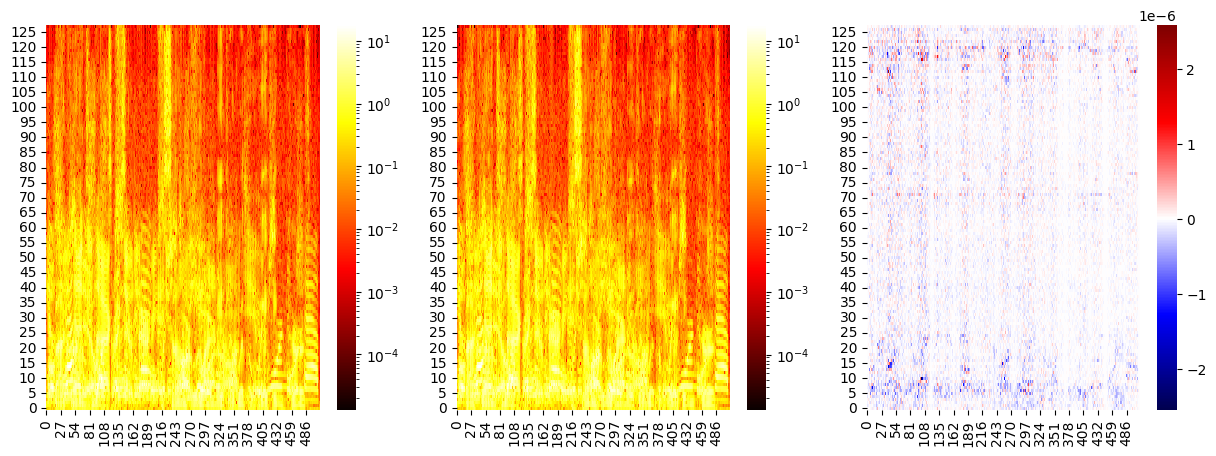

In [46]:
window_size = duet.window_length
n_freq = window_size // 2
n_time = (2 * x.shape[1]) // window_size + 1

cy_stft_deinit()
cy_stft_init(window_size)
cy_window = cy_stft_hamming_window(window_size)
cy_dual_window = cy_stft_dual_window(cy_window)
cy_x = np.ascontiguousarray(xx, dtype=np.float32)
cy_out = np.empty((x.shape[0], n_freq, n_time), dtype=np.complex64)
cy_out_trans = np.empty((x.shape[0], n_time, n_freq), dtype=np.complex64)
cy_temp = np.empty(window_size, dtype=np.float32)

cy_stft(cy_x, cy_window, cy_out, cy_temp, 0, transpose=False)
cy_stft(cy_x, cy_window, cy_out_trans, cy_temp, 0, transpose=True)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(abs(cy_out_trans[0, :, :].T), cmap='hot', norm=LogNorm())
plt.gca().invert_yaxis()

plt.subplot(1, 3, 2)
sns.heatmap(abs(tf[0, :, :]), cmap='hot', norm=LogNorm())
plt.gca().invert_yaxis()

plt.subplot(1, 3, 3)
sns.heatmap(abs(tf[0, :, :]) - abs(cy_out_trans[0, :, :].T), cmap='seismic', center=0)
plt.gca().invert_yaxis()

(np.allclose(duet.stft.win, cy_window),
 np.allclose(duet.stft.dual_win, cy_dual_window),
 np.allclose(duet.stft.f, cy_stft_freqs_raw(window_size, fs)),
 np.allclose(duet.frequencies_f32, cy_stft_freqs(window_size)),
 np.allclose(tf, cy_out, atol=1e-5), np.allclose(tf, cy_out_trans.transpose(0, 2, 1), atol=1e-5)
 )
# TODO: test p0/first_window != 0

True

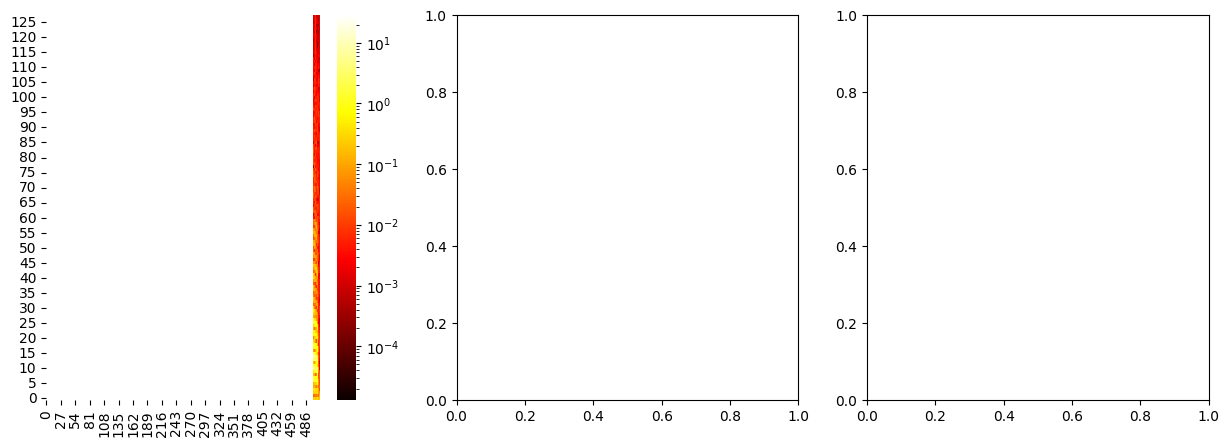

In [47]:
cy_stft_deinit()
cy_stft_init(window_size)

offset = 500  # offset for the first window

cy_out_part = np.zeros((x.shape[0], n_freq, n_time), dtype=np.complex64)
cy_stft(cy_x, cy_window, cy_out_part, cy_temp, first_window=offset)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.heatmap(abs(cy_out_part[0, :, :]), cmap='hot', norm=LogNorm(vmin=abs(cy_out).min(), vmax=abs(cy_out).max()))
plt.gca().invert_yaxis()
plt.subplot(1, 3, 2)
plt.subplot(1, 3, 3)
(cy_out_part[:, :, offset:] == cy_out[:, :, offset:]).all()


In [14]:
%timeit cy_stft_deinit(); cy_stft_init(window_size)  # init short-circuits if already initialized, so deinit first
%timeit cy_stft_hamming_window(window_size)
%timeit cy_stft_dual_window(cy_window)
%timeit cy_stft_freqs_raw(window_size, fs)
%timeit cy_stft_freqs(window_size)

1.33 µs ± 54.3 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
1 µs ± 43.3 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
436 ns ± 17.5 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
353 ns ± 79.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
320 ns ± 52.3 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [426]:
# NOTE: current window size forces radix-2 FFT, picking a different window size may use the faster radix-4 FFT
%timeit duet.stft.stft(xx, p0=0)
%timeit cy_stft(cy_x, cy_window, cy_out_trans, cy_temp, 0, transpose=True)
%timeit cy_stft(cy_x, cy_window, cy_out, cy_temp, 0, transpose=False)
%timeit cy_stft(cy_x, cy_window, cy_out, cy_temp, cy_out.shape[2]-2, transpose=False)

4.81 ms ± 250 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
703 µs ± 32.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.05 ms ± 12.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
4.27 µs ± 271 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [16]:
wave = np.sin(np.linspace(0, 100 * np.pi, 1024, dtype=np.float32)) * 0.6 + \
         np.sin(np.linspace(0, 78 * np.pi, 1024, dtype=np.float32)) * 0.3 + \
         np.sin(np.linspace(0, 61 * np.pi, 1024, dtype=np.float32)) * 0.1

ft = np.fft.rfft(wave).astype(np.complex64)
ift = np.fft.irfft(ft).astype(np.float32)

cy_stft_deinit()
cy_stft_init(1024)
cy_ft = cy_fft(wave)
cy_ift = cy_ifft(cy_ft)

np.allclose(cy_ift, ift, atol=1e-7), np.allclose(wave, ift, atol=1e-7), np.allclose(wave, cy_ift, atol=1e-7)

(True, True, True)

In [111]:
cy_stft_deinit()
cy_stft_init(1024)
cy_ft = cy_fft(np.ascontiguousarray(xx[0,:1024], dtype=np.float32))
cy_ift = cy_ifft(cy_ft)
np.allclose(cy_ift, xx[0,:1024], atol=1e-7)

True

In [112]:
cy_stft_deinit()
cy_stft_init(1024)
inpt = np.ascontiguousarray(xx[0,:1024], dtype=np.float32)
cy_ft = cy_fft(inpt)
%timeit cy_fft(inpt)
%timeit cy_ifft(cy_ft)

4.05 µs ± 349 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
5.94 µs ± 2.05 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


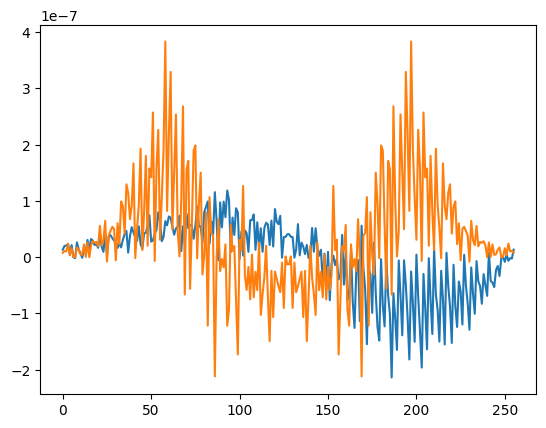

In [15]:
from dumps import WINDOW_dump, DUAL_WINDOW_dump
plt.plot(WINDOW_dump - duet.stft.win)
plt.plot(DUAL_WINDOW_dump - duet.stft.dual_win)

In [87]:
from duet_0000.dump_0012 import audio_dump, spectrogram_dump  # 6656
spectrogram_dump = (spectrogram_dump[..., 0] + 1j * spectrogram_dump[..., 1]).astype(np.complex64)

cy_out_dump = np.empty(spectrogram_dump.shape, dtype=np.complex64)
cy_stft(np.ascontiguousarray(audio_dump[:, :1536], dtype=np.float32), cy_window, cy_out_dump, cy_temp, 0, transpose=False)

# Time slice 12 won't match because in the dump it will have been computed with a zero-padded window
# whereas in the Cython code it will be computed with a full window.
# TODO: Additionally, the very first time slice seems to problems
# TODO: Other time slices improve with time as well, maybe due to rolling or data initialization?
np.allclose(spectrogram_dump[:, :, 1:12], cy_out[:, :, 1:12], atol=5e-6), np.allclose(spectrogram_dump, cy_out_dump, atol=5e-6)

(False, False)

In [88]:
abs(abs(spectrogram_dump[:, :, 1:]) - abs(cy_out_dump[:, :, 1:])).max(), abs(abs(spectrogram_dump[:, :, 1:]) / abs(cy_out_dump[:, :, 1:])).max() - 1

(1.9073486e-06, 0.0003775358200073242)

<Axes: >

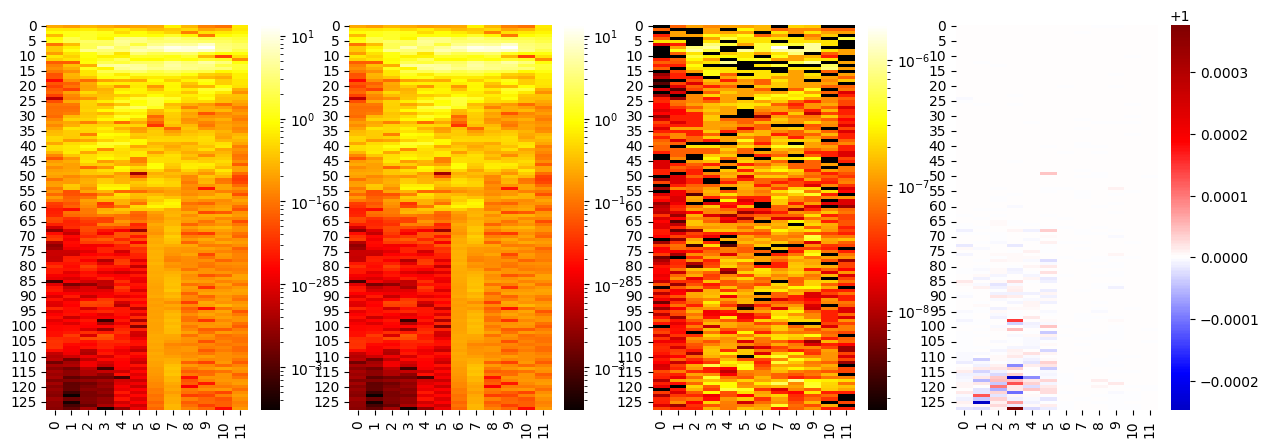

In [93]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
sns.heatmap(abs(spectrogram_dump[0, :, 1:]), cmap='hot', norm=LogNorm())
plt.subplot(1, 4, 2)
sns.heatmap(abs(cy_out_dump[0, :, 1:]), cmap='hot', norm=LogNorm())
plt.subplot(1, 4, 3)
plt.gca().set_facecolor('black')
sns.heatmap(abs(abs(spectrogram_dump[0, :, 1:]) - abs(cy_out_dump[0, :, 1:])), cmap='hot', norm=LogNorm())
plt.subplot(1, 4, 4)
sns.heatmap(abs(abs(spectrogram_dump[0, :, 1:]) / abs(cy_out_dump[0, :, 1:])), cmap='seismic', center=1)

<Axes: >

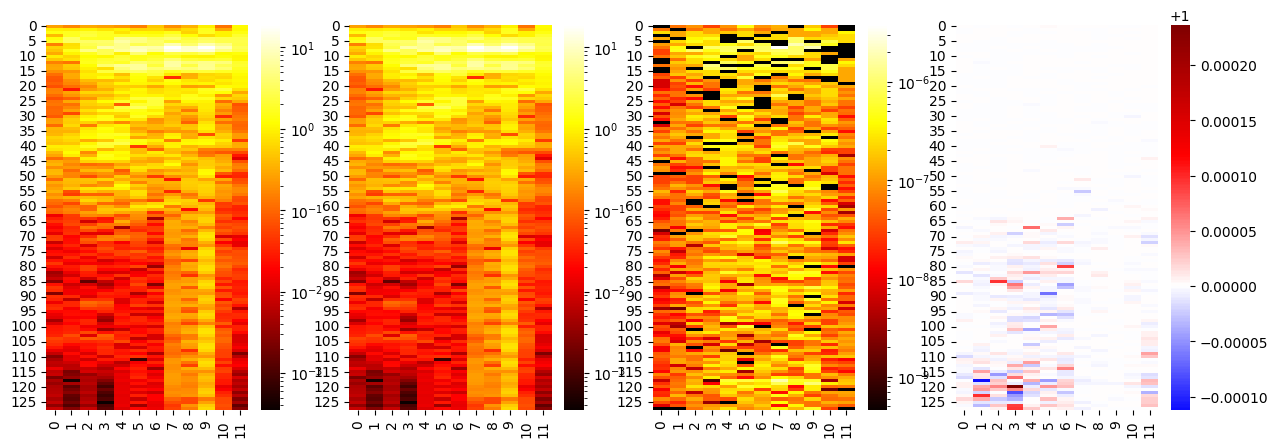

In [94]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
sns.heatmap(abs(spectrogram_dump[1, :, 1:]), cmap='hot', norm=LogNorm())
plt.subplot(1, 4, 2)
sns.heatmap(abs(cy_out_dump[1, :, 1:]), cmap='hot', norm=LogNorm())
plt.subplot(1, 4, 3)
plt.gca().set_facecolor('black')
sns.heatmap(abs(abs(spectrogram_dump[1, :, 1:]) - abs(cy_out_dump[1, :, 1:])), cmap='hot', norm=LogNorm())
plt.subplot(1, 4, 4)
sns.heatmap(abs(abs(spectrogram_dump[1, :, 1:]) / abs(cy_out_dump[1, :, 1:])), cmap='seismic', center=1)

## Compute Attenuation and Delay

In [95]:
%%cython -c=-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION -c=-O3 -c=-ffast-math
cimport numpy as np
import numpy as np

cdef extern from *:
    """
    #include <float.h>
    #include <complex.h>

    static void c_freqs_inv(const float * const freqs, const int n_freq, float * freqs_inv) {
        for (int i = 0; i < n_freq; i++) {
            freqs_inv[i] = 1.0f / freqs[i];
        }
    }

    static void c_compute_atten_and_delay(
        const float complex * const tf, const float * const freqs_inv,
        const int n_freq, const int n_time, const int new_times,
        float* alpha, float* delta
    ) {
        int n_ft = n_freq*n_time;
        const float complex * const tf0 = tf;
        const float complex * const tf1 = &tf[n_ft];
        int old_times = n_time - new_times;
        int i = old_times;
        for (int f = 0; f < n_freq; f++, i += old_times) {
            float freq_inv = freqs_inv[f];
            for (int i_end = i + new_times; i < i_end; i++) {
                float complex lr_ratio = (tf1[i] + FLT_EPSILON) / (tf0[i] + FLT_EPSILON);
                float a = cabsf(lr_ratio);
                alpha[i] = a - 1/a;
                delta[i] = -cargf(lr_ratio) * freq_inv;
            }
        }
    }
    """
    void c_freqs_inv(
        float * freqs,      # in, length n_freq
        int n_freq,
        float * freqs_inv   # out, length n_freq
    ) nogil
    void c_compute_atten_and_delay(
        float complex * tf, # in, shape (n_freq, n_time)
        float * freqs_inv,  # in, length n_freq, precomputed 1 / frequencies
        int n_freq, int n_time, int new_times,
        float* alpha,       # out, shape (n_freq, n_time)
        float* delta,       # out, shape (n_freq, n_time)
    ) nogil

def cy_freqs_inv(np.ndarray[np.float32_t, ndim=1, mode='c'] np_freqs):
    cdef int n_freq = np_freqs.shape[0]
    cdef np.ndarray[np.float32_t, ndim=1, mode='c'] np_freqs_inv = np.empty(n_freq, dtype=np.float32)
    cdef np.float32_t* freqs = &np_freqs[0]
    cdef np.float32_t* freqs_inv = &np_freqs_inv[0]
    with nogil: c_freqs_inv(freqs, n_freq, freqs_inv)
    return np_freqs_inv

def cy_compute_atten_and_delay(
    np.ndarray[np.complex64_t, ndim=3, mode='c'] np_tf,      # in, shape (n_channels, n_freq, n_time)
    np.ndarray[np.float32_t, ndim=1, mode='c'] np_freqs_inv, # in, precomputed 1 / frequencies
    np.ndarray[np.float32_t, ndim=3, mode='c'] np_alpha,     # out, shape (n_channels-1, n_freq, n_time)
    np.ndarray[np.float32_t, ndim=3, mode='c'] np_delta,     # out, shape (n_channels-1, n_freq, n_time)
    int new_times = 0,  # number of new time slices to compute
):
    cdef int n_channels = np_tf.shape[0], n_freq = np_tf.shape[1], n_time = np_tf.shape[2]
    cdef int n_ft = n_freq*n_time, i

    cdef np.complex64_t* tf = &np_tf[0, 0, 0]
    cdef np.float32_t* freqs_inv = &np_freqs_inv[0]
    cdef np.float32_t* alpha = &np_alpha[0, 0, 0]
    cdef np.float32_t* delta = &np_delta[0, 0, 0]

    if new_times == 0:
        new_times = n_time

    with nogil:
        for i in range(n_channels-1):
            c_compute_atten_and_delay(
                tf+i*n_ft, freqs_inv, n_freq, n_time, new_times,
                alpha+i*n_ft, delta+i*n_ft
            )


In [96]:
tf_f32 = tf.astype(np.complex64)
alpha_f32, delta_f32 = duet._compute_attenuation_and_delay(tf_f32)

cy_tf = np.ascontiguousarray(tf_f32)
cy_freq_inv = cy_freqs_inv(duet.frequencies_f32)
cy_alpha = np.empty(tf.shape[1:], np.float32)
cy_delta = np.empty(tf.shape[1:], np.float32)
cy_compute_atten_and_delay(cy_tf, cy_freq_inv, cy_alpha[None], cy_delta[None])

np.allclose(alpha_f32, cy_alpha, atol=1e-6), np.allclose(delta_f32, cy_delta, atol=1e-6)

(True, True)

In [97]:
%timeit cy_freqs_inv(duet.frequencies_f32)
%timeit duet._compute_attenuation_and_delay(tf_f32)
%timeit cy_compute_atten_and_delay(cy_tf, cy_freq_inv, cy_alpha[None], cy_delta[None])

359 ns ± 16.7 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
1 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
788 µs ± 74.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


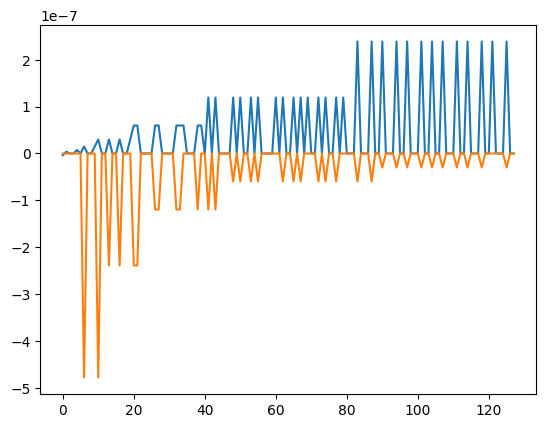

In [98]:
from dumps import FREQUENCIES_dump, FREQUENCIES_INV_dump
plt.plot(FREQUENCIES_dump - duet.frequencies_f32)
plt.plot(FREQUENCIES_INV_dump - cy_freq_inv)

In [100]:
from duet_0000.dump_0012 import spectrogram_dump, alpha_dump, delta_dump
spectrogram_dump = (spectrogram_dump[..., 0] + 1j * spectrogram_dump[..., 1]).astype(np.complex64)
cy_alpha_dump = np.zeros_like(cy_alpha[:, :13])
cy_delta_dump = np.zeros_like(cy_delta[:, :13])
cy_compute_atten_and_delay(spectrogram_dump.astype(np.complex64), cy_freq_inv, cy_alpha_dump[None], cy_delta_dump[None])

# last frequency has several -1 instead of +1, but cyclic so technically correct
np.allclose(alpha_dump, cy_alpha_dump, rtol=2e-4), np.allclose(delta_dump[:-1], cy_delta_dump[:-1], rtol=1e-3), np.allclose(abs(delta_dump[-1]), abs(cy_delta_dump[-1]), rtol=1e-5)

(True, True, True)

/var/folders/g6/5ptt9_c110g8jw7kpmtks0vdwrpvb9/T/ipykernel_41563/2410313621.py:5: RuntimeWarning: invalid value encountered in divide
  sns.heatmap(abs(delta_dump / cy_delta_dump) - 1, cmap='seismic', center=0)


(0.99999994, 0.9999471, 1.0000143, 0.9999344, 0.999215, 1.0001867)

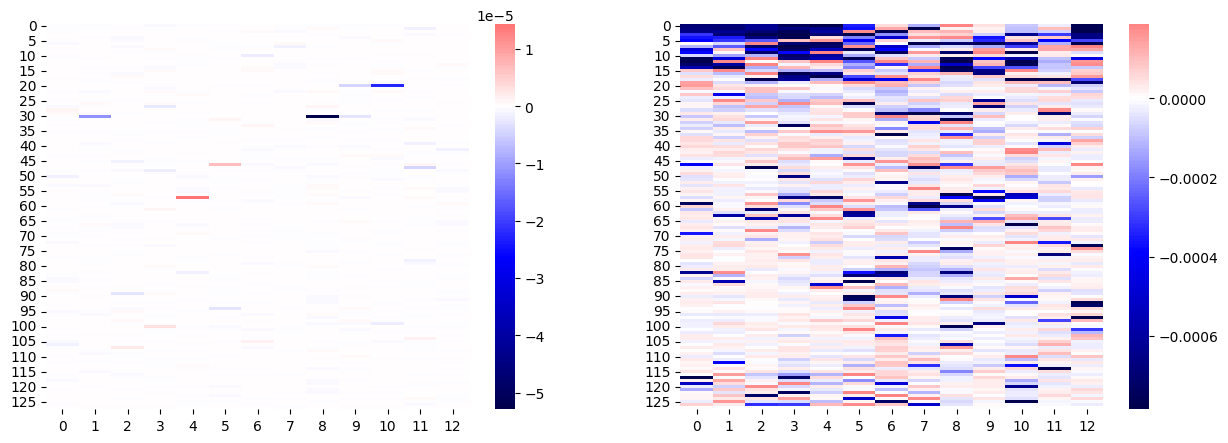

In [101]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.heatmap(abs(alpha_dump / cy_alpha_dump) - 1, cmap='seismic', center=0)
plt.subplot(1, 2, 2)
sns.heatmap(abs(delta_dump / cy_delta_dump) - 1, cmap='seismic', center=0)
delta_dump_nz = delta_dump[cy_delta_dump != 0]
cy_delta_dump_nz = cy_delta_dump[cy_delta_dump != 0]
abs(alpha_dump / cy_alpha_dump).mean(), abs(alpha_dump / cy_alpha_dump).min(), abs(alpha_dump / cy_alpha_dump).max(), abs(delta_dump_nz / cy_delta_dump_nz).mean(), abs(delta_dump_nz / cy_delta_dump_nz).min(), abs(delta_dump_nz / cy_delta_dump_nz).max()

## Compute Weights

In [56]:
%%cython -c=-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION -c=-O3 -c=-ffast-math
cimport numpy as np
import numpy as np

cdef extern from *:
    """
    #include <float.h>
    #include <complex.h>
    #include <math.h>
    const float P = 1.0f;
    const float Q = 0.0f;

    static void c_freqs_pow_q(const float * const freqs, const int n_freq, float * freqs_freqs_pow_q) {
        if (Q == 0.0f) {
            for (int i = 0; i < n_freq; i++) { freqs_freqs_pow_q[i] = 1.0f; }
        } else {
            for (int i = 0; i < n_freq; i++) { freqs_freqs_pow_q[i] = powf(fabsf(freqs[i]), Q); }
        }
    }

    static void c_compute_weights(
        const float complex * const tf,
        const float * const freqs_pow_q,  // precomputed pow(fabs(freqs), q)
        const int n_freq, const int n_time, const int new_times,
        float* tf_weights
    ) {
        int n_ft = n_freq*n_time;
        const float complex * const tf0 = tf;
        const float complex * const tf1 = &tf[n_ft];
        int old_times = n_time - new_times;
        int i = old_times;
        for (int f = 0; f < n_freq; f++, i += old_times) {
            float freq_pow_q = freqs_pow_q[f];
            for (int i_end = i + new_times; i < i_end; i++) {
                float tf_weight = cabsf(tf0[i]) * cabsf(tf1[i]);  // TODO: optimize (there are sqrts in it)?
                if (P != 1.0f) { tf_weight = powf(tf_weight, P); }
                if (Q != 0.0f) { tf_weight *= freq_pow_q; }
                tf_weights[i] = tf_weight;
            }
        }
    }

    """
    void c_freqs_pow_q(
        float * freqs,       # in, length n_freq
        int n_freq,
        float * freqs_pow_q  # out, length n_freq
    ) nogil
    void c_compute_weights(
        float complex * tf, # in, shape (n_freq, n_time)
        float* freqs_pow_q, # in, length n_freq, precomputed pow(fabs(freqs), q)
        int n_freq, int n_time, int new_times,
        float* tf_weights   # out, shape (n_freq, n_time)
    ) nogil

def cy_freqs_pow_q(np.ndarray[np.float32_t, ndim=1, mode='c'] np_freqs):
    cdef int n_freq = np_freqs.shape[0]
    cdef np.ndarray[np.float32_t, ndim=1, mode='c'] np_freqs_pow_q = np.empty(n_freq, dtype=np.float32)
    cdef np.float32_t* freqs = &np_freqs[0]
    cdef np.float32_t* freqs_pow_q = &np_freqs_pow_q[0]
    with nogil: c_freqs_pow_q(freqs, n_freq, freqs_pow_q)
    return np_freqs_pow_q

def cy_compute_weights(
    np.ndarray[np.complex64_t, ndim=3, mode='c'] np_tf,        # in, shape (n_channels, n_freq, n_time)
    np.ndarray[np.float32_t, ndim=1, mode='c'] np_freqs_pow_q, # in, length n_freq, precomputed pow(fabs(freqs), q)
    np.ndarray[np.float32_t, ndim=3, mode='c'] np_tf_weights,  # out, shape (n_channels-1, n_freq, n_time)
    int new_times=0
):
    cdef int n_channels = np_tf.shape[0], n_freq = np_tf.shape[1], n_time = np_tf.shape[2]
    cdef int n_ft = n_freq*n_time, i

    cdef np.complex64_t* tf = &np_tf[0, 0, 0]
    cdef np.float32_t* freqs_pow_q = &np_freqs_pow_q[0]
    cdef np.float32_t* tf_weights = &np_tf_weights[0, 0, 0]

    if new_times == 0:
        new_times = n_time

    with nogil:
        for i in range(n_channels-1):
            c_compute_weights(tf+i*n_ft, freqs_pow_q, n_freq, n_time, new_times, tf_weights+i*n_ft)


In [58]:
tf_f32 = tf.astype(np.complex64)  # convert to float32 for testing
tf_weights_f32 = duet._compute_weights(tf_f32)
cy_tf = np.ascontiguousarray(tf_f32)
cy_freqs_pow_q_ = cy_freqs_pow_q(duet.frequencies_f32)
cy_tf_weights = np.empty(tf.shape[1:], np.float32)
cy_compute_weights(cy_tf, cy_freqs_pow_q_, cy_tf_weights[None])
np.allclose(tf_weights_f32, cy_tf_weights, atol=1e-6)

True

In [553]:
%timeit cy_freqs_pow_q(duet.frequencies_f32)
%timeit duet._compute_weights(tf_f32)
%timeit cy_compute_weights(cy_tf, cy_freqs_pow_q_, cy_tf_weights[None])

387 ns ± 46.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
108 µs ± 3.37 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
16.4 µs ± 184 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


(True, 0.9999995, 1.0000005)

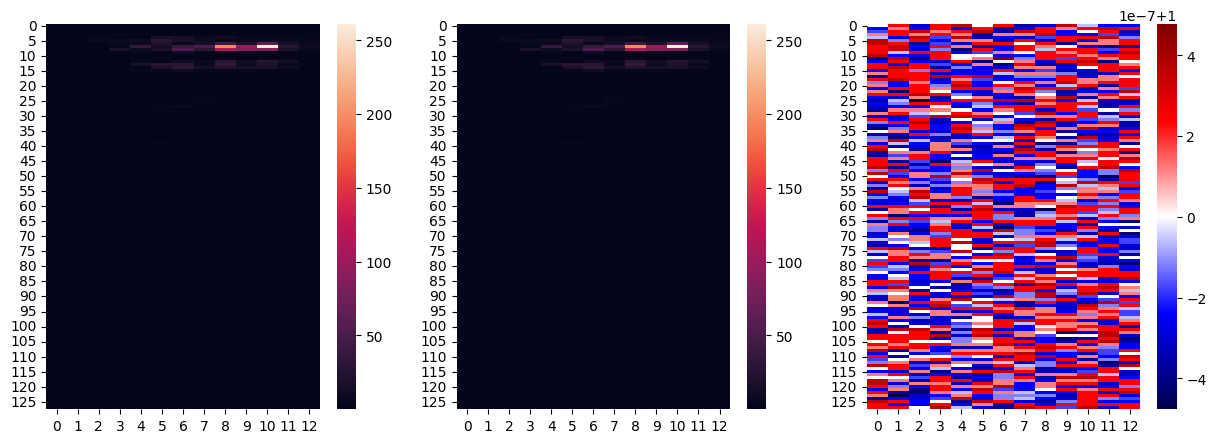

In [102]:
from duet_0000.dump_0012 import spectrogram_dump, weights_dump
spectrogram_dump = (spectrogram_dump[..., 0] + 1j * spectrogram_dump[..., 1]).astype(np.complex64)
cy_tf_weights_dump = np.zeros_like(cy_tf_weights[:, :13])
cy_compute_weights(spectrogram_dump, cy_freqs_pow_q_, cy_tf_weights_dump[None])
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.heatmap(weights_dump[:, :13])
plt.subplot(1, 3, 2)
sns.heatmap(cy_tf_weights_dump[:, :13])
plt.subplot(1, 3, 3)
sns.heatmap(weights_dump[:, :13] / cy_tf_weights_dump[:, :13], cmap='seismic', center=1)
np.allclose(weights_dump, cy_tf_weights_dump), np.min(weights_dump[:, :13] / cy_tf_weights_dump[:, :13]), np.max(weights_dump[:, :13] / cy_tf_weights_dump[:, :13])

## Find Peaks (MS)

In [62]:
%%cython -c=-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION -c=-O3 -c=-ffast-math -I. -Smean_shift.c -f
#cython: boundscheck=False
#cython: wraparound=False
#cython: cdivision=True
cimport numpy as np
import numpy as np

from libc.stdint cimport int32_t

cdef extern from "mean_shift.h":
    """
#include <stdint.h>

#define ATTENUATION_MAX 3.6f
#define DELAY_MAX 3.6f

static int get_ms_points(
    const float * const tf_weights, // in, shape (N_CHANNELS-1, N_FREQ, N_TIME)
    const float * const alpha,      // in, shape (N_CHANNELS-1, N_FREQ, N_TIME)
    const float * const delta,      // in, shape (N_CHANNELS-1, N_FREQ, N_TIME)
    const int n_channels, const int n_freq, const int n_time,
    const float point_threshold, // threshold for points to consider
    float * points,                 // out, shape (n_pts, MEAN_SHIFT_DIM) where MEAN_SHIFT_DIM = 2*(N_CHANNELS-1)
    float * weights                 // out, length n_pts
) {
    const int N_FREQ_TIME = n_freq * n_time;
    const int N_CHANNELS = n_channels;

    int j = 0;
    for (int i = 0; i < N_FREQ_TIME; i++) {
        if (tf_weights[i] <= point_threshold) { continue; }

        // NOTE: this alternates alphas and deltas, the original Python code instead places all
        // alphas first and then all deltas. Only changes how mean-shift works, not the results.
        const float * const alpha_i = &alpha[i];
        const float * const delta_i = &delta[i];
        float* point = &points[j*2*(N_CHANNELS-1)];
        for (int c = 0; c < N_CHANNELS-1; c++) {
            float a = alpha_i[c*N_FREQ_TIME];
            float d = delta_i[c*N_FREQ_TIME];
            // Make sure the values are within the limits
            if (fabsf(a) > ATTENUATION_MAX || fabsf(d) > DELAY_MAX) { goto outer_continue; }
            point[c*2] = a;
            point[c*2+1] = d;
        }
        weights[j++] = tf_weights[i];
        outer_continue:;
    }
    return j; // number of points found
}


static int32_t find_peaks(
    const float * const tf_weights, // in, shape (N_CHANNELS-1, N_FREQ, N_TIME)
    const float * const alpha,      // in, shape (N_CHANNELS-1, N_FREQ, N_TIME)
    const float * const delta,      // in, shape (N_CHANNELS-1, N_FREQ, N_TIME)
    const int n_channels, const int n_freq, const int n_time,
    const int max_sources,
    const int min_bin_count,        // minimum number of points in a bin in MS or 1 for all
    const int seed_count,           // number of seeds to use in MS or 0 for all
    const float point_threshold,    // threshold for points to consider
    float * alpha_peaks,            // out, shape (n_sources, N_CHANNELS-1)
    float * delta_peaks             // out, shape (n_sources, N_CHANNELS-1)
) {
    const int N_FREQ_TIME = n_freq * n_time;
    const int N_CHANNELS = n_channels;

    // TODO: consider putting these on the heap instead of the stack
    //       the points/weights can also grow dynamically (unlikely to need anywhere near N_FREQ_TIME points or 256 seeds)
    float points[N_FREQ_TIME*2*(N_CHANNELS-1)];  // MEAN_SHIFT_DIM == 2*(N_CHANNELS-1)
    float weights[N_FREQ_TIME];
    int n_pts = get_ms_points(tf_weights, alpha, delta,
        n_channels, n_freq, n_time, point_threshold, points, weights);
    float centroids[256*2*(N_CHANNELS-1)];  // actual constant here (MEAN_SHIFT_HIST_SIZE) or seed_count if not 0 and <HIST_SIZE
    int n_seeds = compute_mean_shift_seeds(points, n_pts, min_bin_count, seed_count, centroids);
    if (n_seeds == 0) { return 0; }
    int n_peaks = mean_shift(points, n_pts, weights, centroids, n_seeds, 0.1f);
/*    if ((N_CHANNELS-1) > 1) {
        for (int i = 0; i < n_peaks; i++) {
            for (int c = 0; c < N_CHANNELS-1; c++) {
                alpha_peaks[i*(N_CHANNELS-1) + c] = centroids[i*2*(N_CHANNELS-1) + c*2];
                delta_peaks[i*(N_CHANNELS-1) + c] = centroids[i*2*(N_CHANNELS-1) + c*2+1];
            }
        }

        // TODO: support >2 channels
    } else {*/
        for (int i = 0; i < n_peaks; i++) {
            alpha_peaks[i] = centroids[i*2];
            delta_peaks[i] = centroids[i*2+1];
        }
    //}
    return n_peaks;
}
    """
    void init_mean_shift() nogil
    int compute_mean_shift_seeds(float* points, int n, int min_count, int top_n, float * output) nogil
    int mean_shift(float* points, int n, float * weights, float * centroids, int m, float tol) nogil
    int get_ms_points(
        const float * const tf_weights, # in, shape (N_CHANNELS-1, N_FREQ, N_TIME)
        const float * const alpha,      # in, shape (N_CHANNELS-1, N_FREQ, N_TIME)
        const float * const delta,      # in, shape (N_CHANNELS-1, N_FREQ, N_TIME)
        const int n_channels,           # number of channels (N_CHANNELS-1)
        const int n_freq,               # number of frequencies (N_FREQ)
        const int n_time,               # number of time slices (N_TIME)
        const float point_threshold,    # threshold for points to consider
        float * points,                 # out, shape (n_pts, MEAN_SHIFT_DIM) where MEAN_SHIFT_DIM = 2*(N_CHANNELS-1)
        float * weights                 # out, length n_pts
    ) nogil
    int32_t find_peaks(
        const float * const tf_weights, # in, shape (N_CHANNELS-1, N_FREQ, N_TIME)
        const float * const alpha,      # in, shape (N_CHANNELS-1, N_FREQ, N_TIME)
        const float * const delta,      # in, shape (N_CHANNELS-1, N_FREQ, N_TIME)
        const int n_channels,           # number of channels (N_CHANNELS-1)
        const int n_freq,               # number of frequencies (N_FREQ)
        const int n_time,               # number of time slices (N_TIME)
        const int max_sources,
        const int min_bin_count,        # minimum number of points in a bin in MS or 1 for all
        const int seed_count,           # number of seeds to use in MS or 0 for all
        const float point_threshold,    # threshold for points to consider
        float * alpha_peaks,            # out, shape (n_sources, N_CHANNELS-1)
        float * delta_peaks             # out, shape (n_sources, N_CHANNELS-1)
    ) nogil

def cy_init_mean_shift():
    with nogil: init_mean_shift()

def cy_compute_mean_shift_seeds(
    np.ndarray[np.float32_t, ndim=2, mode='c'] points,  # in, shape (n, n_features)
    np.ndarray[np.float32_t, ndim=2, mode='c'] output,  # out, shape (m, n_features)
    int min_count=10,  # minimum number of points in a cluster to consider it a seed
    int top_n=10,      # number of seeds to return
):
    cdef int n = points.shape[0], m = points.shape[1], count
    cdef np.float32_t* points_ptr = &points[0, 0]
    cdef np.float32_t* output_ptr = &output[0, 0]
    with nogil:
        count = compute_mean_shift_seeds(points_ptr, n, min_count, top_n, output_ptr)
    return count

def cy_mean_shift(
    np.ndarray[np.float32_t, ndim=2, mode='c'] points,     # in, shape (n, n_features)
    np.ndarray[np.float32_t, ndim=1, mode='c'] weights,    # in, shape (n,)
    np.ndarray[np.float32_t, ndim=2, mode='c'] centroids,  # in, shape (m, n_features)
    float tol=1e-3,  # tolerance for convergence
):
    cdef int n = points.shape[0], m = points.shape[1], count
    cdef np.float32_t* points_ptr = &points[0, 0]
    cdef np.float32_t* weights_ptr = &weights[0]
    cdef np.float32_t* centroids_ptr = &centroids[0, 0]
    with nogil:
        count = mean_shift(points_ptr, n, weights_ptr, centroids_ptr, m, tol)
    return count

def cy_get_ms_points(
    np.ndarray[np.float32_t, ndim=3, mode='c'] tf_weights,  # in, shape (n_channels-1, n_freq, n_time)
    np.ndarray[np.float32_t, ndim=3, mode='c'] alpha,       # in, shape (n_channels-1, n_freq, n_time)
    np.ndarray[np.float32_t, ndim=3, mode='c'] delta,       # in, shape (n_channels-1, n_freq, n_time)
    float point_threshold,  # threshold for points to consider
    np.ndarray[np.float32_t, ndim=2, mode='c'] points_out,  # out, shape (n_pts, 2*(n_channels-1))
    np.ndarray[np.float32_t, ndim=1, mode='c'] weights_out  # out, length n_pts
):
    cdef int n_channels = tf_weights.shape[0] + 1, n_freq = tf_weights.shape[1], n_time = tf_weights.shape[2]
    cdef int n_pts = points_out.shape[0], count

    cdef np.float32_t* tf_weights_ptr = &tf_weights[0, 0, 0]
    cdef np.float32_t* alpha_ptr = &alpha[0, 0, 0]
    cdef np.float32_t* delta_ptr = &delta[0, 0, 0]
    cdef np.float32_t* points_out_ptr = &points_out[0, 0]
    cdef np.float32_t* weights_out_ptr = &weights_out[0]

    with nogil:
        count = get_ms_points(tf_weights_ptr, alpha_ptr, delta_ptr,
                              n_channels, n_freq, n_time, point_threshold,
                              points_out_ptr, weights_out_ptr)
    return count

def cy_init_mean_shift():
    with nogil: init_mean_shift()

def cy_compute_mean_shift_seeds(
    np.ndarray[np.float32_t, ndim=2, mode='c'] points,
    int min_count, int top_n,
    np.ndarray[np.float32_t, ndim=2, mode='c'] output
):
    cdef int n = points.shape[0], m = points.shape[1], count
    cdef np.float32_t* points_ptr = &points[0, 0]
    cdef np.float32_t* output_ptr = &output[0, 0]
    with nogil:
        count = compute_mean_shift_seeds(points_ptr, n, min_count, top_n, output_ptr)
    return count

def cy_mean_shift(
    np.ndarray[np.float32_t, ndim=2, mode='c'] points,  # in, shape (n, n_features)
    np.ndarray[np.float32_t, ndim=1, mode='c'] weights,  # in, shape (n,)
    np.ndarray[np.float32_t, ndim=2, mode='c'] centroids,  # in, shape (m, n_features)
    float tol=1e-3  # tolerance for convergence
):
    cdef int n = points.shape[0], m = centroids.shape[0], count
    cdef np.float32_t* points_ptr = &points[0, 0]
    cdef np.float32_t* weights_ptr = &weights[0]
    cdef np.float32_t* centroids_ptr = &centroids[0, 0]
    with nogil:
        count = mean_shift(points_ptr, n, weights_ptr, centroids_ptr, m, tol)
    return count

def cy_find_peaks(
    np.ndarray[np.float32_t, ndim=3, mode='c'] tf_weights,  # in, shape (n_channels-1, n_freq, n_time)
    np.ndarray[np.float32_t, ndim=3, mode='c'] alpha,       # in, shape (n_channels-1, n_freq, n_time)
    np.ndarray[np.float32_t, ndim=3, mode='c'] delta,       # in, shape (n_channels-1, n_freq, n_time)
    int min_bin_count,  # minimum number of points in a bin in MS or 1 for all
    int seed_count,  # number of seeds to use in MS or 0 for all
    float point_threshold,  # threshold for points to consider
    np.ndarray[np.float32_t, ndim=2, mode='c'] alpha_peaks,  # out, shape (n_sources, n_channels-1)
    np.ndarray[np.float32_t, ndim=2, mode='c'] delta_peaks   # out, shape (n_sources, n_channels-1)
):
    cdef int n_channels = tf_weights.shape[0] + 1, n_freq = tf_weights.shape[1], n_time = tf_weights.shape[2]
    cdef int max_sources = alpha_peaks.shape[0], count
    cdef np.float32_t* tf_weights_ptr = &tf_weights[0, 0, 0]
    cdef np.float32_t* alpha_ptr = &alpha[0, 0, 0]
    cdef np.float32_t* delta_ptr = &delta[0, 0, 0]
    cdef np.float32_t* alpha_peaks_ptr = &alpha_peaks[0, 0]
    cdef np.float32_t* delta_peaks_ptr = &delta_peaks[0, 0]
    with nogil:
        count = find_peaks(tf_weights_ptr, alpha_ptr, delta_ptr,
                           n_channels, n_freq, n_time,
                           max_sources, min_bin_count, seed_count, point_threshold,
                           alpha_peaks_ptr, delta_peaks_ptr)
    return count


Content of stderr:
/Users/bushj/.cache/ipython/cython/_cython_magic_926a72a4b902785a0ffb2ed46f0dcfbad0d19b07.c:9403:26: warning: code will never be executed [-Wunreachable-code]
 9403 |                 module = PyImport_ImportModuleLevelObject(
      |                          ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1 warning generated.
/Users/bushj/.cache/ipython/cython/_cython_magic_926a72a4b902785a0ffb2ed46f0dcfbad0d19b07.c:9403:26: warning: code will never be executed [-Wunreachable-code]
 9403 |                 module = PyImport_ImportModuleLevelObject(
      |                          ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1 warning generated.
mean_shift.c:52:20: warning: variable length array folded to constant array as an extension [-Wgnu-folding-constant]
   52 | const float BOUNDS[DIM * 2] = {
      |                    ^~~~~~~
mean_shift.c:57:25: warning: variable length array folded to constant array as an extension [-Wgnu-folding-constant]
   57 | int_fast16_t HIST_SHAPE[DIM];
      | 

In [63]:
cy_tf_weights = np.ascontiguousarray(tf_weights, dtype=np.float32)
cy_alpha = np.ascontiguousarray(alpha, dtype=np.float32)
cy_delta = np.ascontiguousarray(delta, dtype=np.float32)

cy_pts_out = np.empty((cy_alpha.size, 2), dtype=np.float32)
cy_weights_out = np.empty(cy_alpha.size, dtype=np.float32)

(pts_out, weights_out) = duet._get_points(tf_weights, alpha, delta)

count = cy_get_ms_points(cy_tf_weights[None], cy_alpha[None], cy_delta[None], duet.threshold, cy_pts_out, cy_weights_out)
cy_pts_out = cy_pts_out[:count]
cy_weights_out = cy_weights_out[:count]

count, np.allclose(pts_out, cy_pts_out), np.allclose(weights_out, cy_weights_out)

(8689, True, True)

In [64]:
cy_init_mean_shift()

centroids = get_seeds(cy_pts_out, duet._bandwidths(), duet.min_bin_count, duet.seed_count)

cy_centroids = np.empty((256, 2), dtype=np.float32)
count = cy_compute_mean_shift_seeds(cy_pts_out, duet.min_bin_count, duet.seed_count, cy_centroids)
cy_centroids = cy_centroids[:count, :]
cy_centroids_orig = cy_centroids.copy()

# they end up in a different order, but the values are the same
np.allclose(np.sort(centroids, axis=0), np.sort(cy_centroids, axis=0), atol=1e-6), count

(True, 25)

In [65]:
peaks = mean_shift(cy_pts_out, make_gaussian_kernel(duet._bandwidths(), cy_weights_out), cy_centroids, np.min(duet._bandwidths()), duet.convergence_tol)

cy_centroids = cy_centroids_orig.copy()
count = cy_mean_shift(cy_pts_out, cy_weights_out, cy_centroids, duet.convergence_tol)
cy_centroids = cy_centroids[:count, :]

# they end up in a different order, but the values are the same
np.allclose(np.sort(peaks, axis=0), np.sort(cy_centroids, axis=0), atol=1e-6), count

(False, 5)

1664
237
(16, 2)


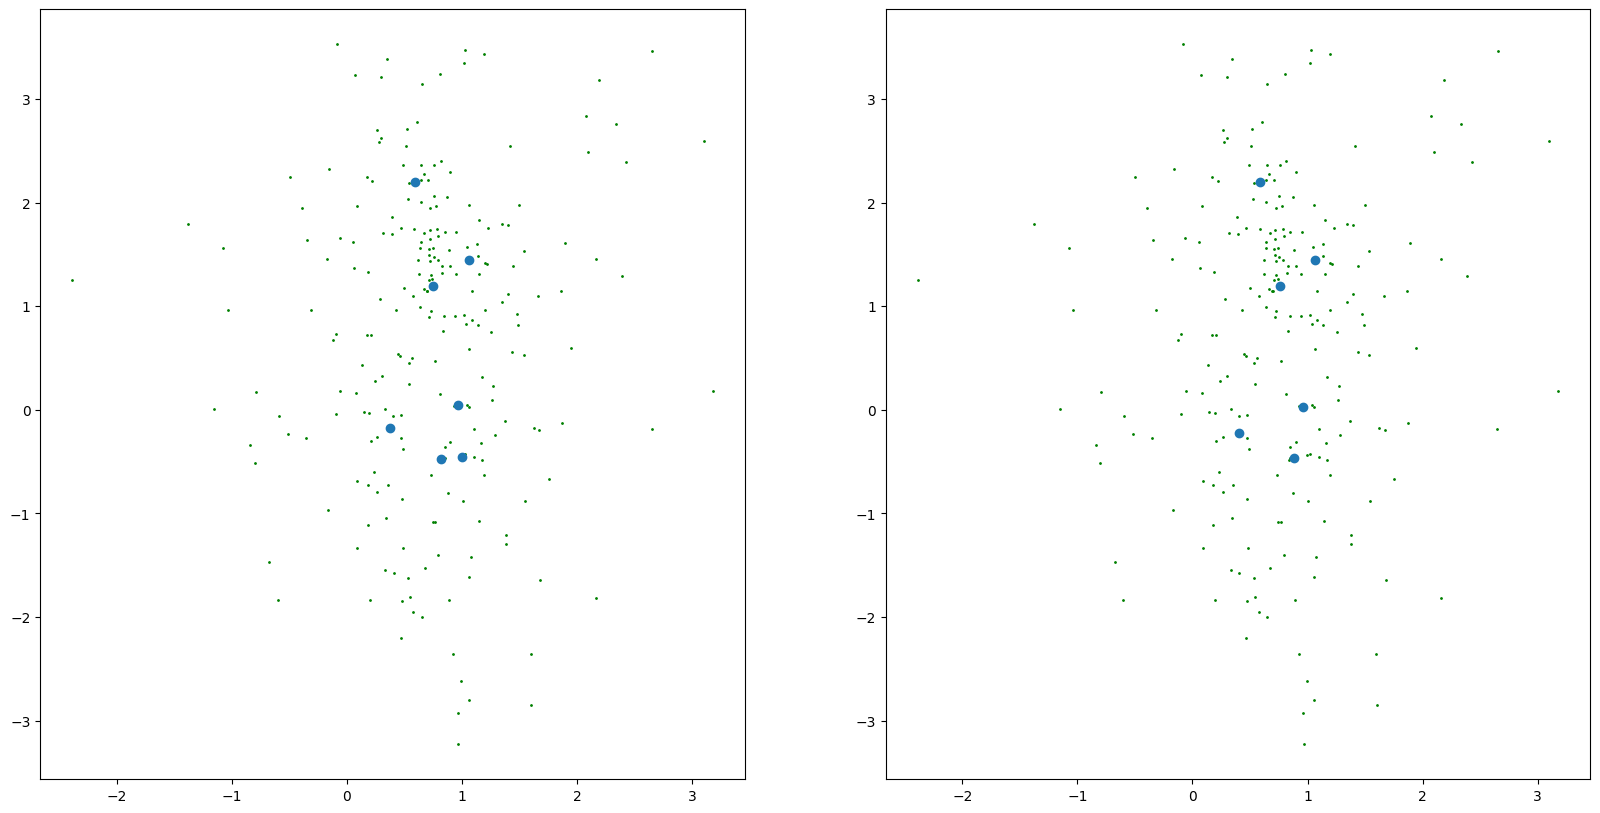

In [108]:
from duet_0000.dump_0012 import alpha_dump, delta_dump, weights_dump
print(weights_dump.size)
(pts_from_dump, weights_from_dump) = duet._get_points(weights_dump, alpha_dump, delta_dump)
print(weights_from_dump.size)
seeds_from_dump = get_seeds(pts_from_dump, (0.2, 0.2), 3, 20, duet._bounds())  # duet._bandwidths()
print(seeds_from_dump.shape)
out = mean_shift(pts_from_dump, make_gaussian_kernel(#duet._bandwidths(),
    (0.2, 0.2), weights_from_dump), seeds_from_dump, np.min(duet._bandwidths()), duet.convergence_tol)


#seeds_dump = np.array([1.49011612e-07, 1.60000014, 0.400000155, 1.40000021, 0.400000155, 2.00000024, 0.600000143, -1.19999981, 0.600000143, -0.599999845, 0.600000143, 1.20000017, 0.800000191, 1.00000012, 0.800000191, 1.20000017, 0.800000191, 1.40000021, 0.800000191, 1.60000014, 0.800000191, 1.80000019, 1.00000012, 0.400000155, 1.00000012, 1.00000012, 1.00000012, 1.40000021, 1.00000012, 1.60000014, 1.00000012, 1.80000019, 1.20000017, 1.40000021, ], np.float32).reshape((-1, 2))
#alpha_peaks_dump = np.array([0.42754966, 0.530739844, 0.588681519, 0.583300531, 0.975852489, ], np.float32).reshape(5)
#delta_peaks_dump = np.array([1.92765343, 1.42555249, -1.20444441, -0.604552805, 0.434531927, ], np.float32).reshape(5)
from duet_0000.dump_0012 import alpha_peaks_dump, delta_peaks_dump

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.scatter(pts_from_dump[:, 0], pts_from_dump[:, 1], marker='o', s=1, c='g', label='Points')  # cy_weights_out/cy_weights_out.max()
#plt.scatter(seeds_dump[:, 0], seeds_dump[:, 1], marker='x', s=50, color='red', label='Centroids')
plt.scatter(alpha_peaks_dump, delta_peaks_dump)

plt.subplot(1, 2, 2)
plt.scatter(pts_from_dump[:, 0], pts_from_dump[:, 1], marker='o', s=1, c='g', label='Points')  # cy_weights_out/cy_weights_out.max()
#plt.scatter(seeds_from_dump[:, 0], seeds_from_dump[:, 1], marker='x', s=50, color='red', label='Centroids')
plt.scatter(out[:, 0], out[:, 1])

In [76]:
alpha_peaks, delta_peaks = duet._find_peaks(tf_weights, alpha, delta)

cy_alpha_peaks = np.zeros((128, 1), dtype=np.float32)
cy_delta_peaks = np.zeros((128, 1), dtype=np.float32)
count = cy_find_peaks(cy_tf_weights[None], cy_alpha[None], cy_delta[None], duet.min_bin_count, duet.seed_count, duet.threshold, cy_alpha_peaks, cy_delta_peaks)
count, cy_alpha_peaks[:count], cy_delta_peaks[:count]

(5,
 array([[-0.11466217],
        [ 0.135309  ],
        [ 0.4162484 ],
        [ 0.6586391 ],
        [ 1.0065371 ]], dtype=float32),
 array([[ 0.5786103],
        [ 1.1813936],
        [-1.3816696],
        [ 1.4621592],
        [-0.5532768]], dtype=float32))

In [54]:
%timeit duet._get_points(tf_weights, alpha, delta)
%timeit cy_get_ms_points(cy_tf_weights[None], cy_alpha[None], cy_delta[None], duet.threshold, cy_pts_out, cy_weights_out)

322 µs ± 21.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
60.8 µs ± 1.81 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [21]:
%timeit get_seeds(cy_pts_out, duet._bandwidths(), duet.min_bin_count, duet.seed_count)
%timeit cy_compute_mean_shift_seeds(cy_pts_out, duet.min_bin_count, duet.seed_count, cy_centroids)

772 µs ± 27.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
4.84 µs ± 323 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [68]:
%timeit mean_shift(cy_pts_out, make_gaussian_kernel(duet._bandwidths(), cy_weights_out), cy_centroids_orig, np.min(duet._bandwidths()), duet.convergence_tol)
%timeit cy_mean_shift(cy_pts_out, cy_weights_out, cy_centroids_orig.copy(), duet.convergence_tol)

27 ms ± 4.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.83 ms ± 5.12 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [69]:
%timeit duet._find_peaks(tf_weights, alpha, delta)
%timeit cy_find_peaks(cy_tf_weights[None], cy_alpha[None], cy_delta[None], duet.min_bin_count, duet.seed_count, duet.threshold, cy_alpha_peaks, cy_delta_peaks)
# 4.5 ms originally

39.8 ms ± 4.95 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.91 ms ± 37 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Convert Symmetric Attenuation to Regular Attenuation

In [45]:
%%cython -c=-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION -c=-O3 -c=-ffast-math
cimport numpy as np
import numpy as np

cdef extern from *:
    """
    #include <math.h>

    static void c_convert_sym_to_atn(
        const float * const sym_atn,
        const int n_sources,
        float * atn
    ) {
        for (int i = 0; i < n_sources; i++) {
            float sym = sym_atn[i];
            atn[i] = 0.5f * (sym + sqrtf(sym * sym + 4)); // TODO: use DSP sqrt
        }
    }
    """
    void c_convert_sym_to_atn(
        float * sym_atn,  # in, length n_sources
        int n_sources,
        float * atn       # out, length n_sources
    ) nogil
    

def cy_convert_sym_to_atn(
    np.ndarray[np.float32_t, ndim=1, mode='c'] np_sym_atn, # in, length n_sources
    np.ndarray[np.float32_t, ndim=1, mode='c'] np_atn      # out, length n_sources
):
    cdef int n_sources = np_sym_atn.shape[0]
    cdef np.float32_t* sym_atn = &np_sym_atn[0]
    cdef np.float32_t* atn = &np_atn[0]
    with nogil: c_convert_sym_to_atn(sym_atn, n_sources, atn)


In [61]:
sym_atn_peaks_f32 = sym_atn_peaks.astype(np.float32)
cy_sym_atn_peaks = np.ascontiguousarray(sym_atn_peaks_f32)
cy_atn_peaks = np.empty(sym_atn_peaks.shape, dtype=np.float32)
cy_convert_sym_to_atn(cy_sym_atn_peaks, cy_atn_peaks)
np.allclose(cy_atn_peaks, atn_peaks.astype(np.float32))

True

In [48]:
%timeit duet._convert_sym_to_atn(sym_atn_peaks_f32)
%timeit cy_convert_sym_to_atn(cy_sym_atn_peaks, cy_atn_peaks)

2.4 µs ± 162 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
169 ns ± 12.1 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [109]:
#alpha_peaks_sym_dump = np.array([1.23636937, 1.29998147, 1.33675933, 1.33331239, 1.60061312, ], np.float32).reshape(5)
from duet_0000.dump_0012 import alpha_peaks_sym_dump, alpha_peaks_dump
np.allclose(duet._convert_sym_to_atn(alpha_peaks_dump), alpha_peaks_sym_dump), np.max(abs(duet._convert_sym_to_atn(alpha_peaks_dump) / alpha_peaks_sym_dump)), np.min(abs(duet._convert_sym_to_atn(alpha_peaks_dump) / alpha_peaks_sym_dump))

(True, 1.0000002, 1.0000001)

## Compute Sources

In [113]:
%%cython -c=-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION -c=-O3 -c=-ffast-math
cimport numpy as np
import numpy as np
from libc.stdint cimport uint8_t

cdef extern from *:
    """
    #include <float.h>
    #include <complex.h>
    #include <stdint.h>

    static inline float cabsf2(float complex x) {
        // squared cabsf(x), avoids the sqrtf call
        return crealf(x) * crealf(x) + cimagf(x) * cimagf(x);
    }

    static void c_compute_sources(
        const float complex * const spectrogram, // in, shape (n_channels, n_freq, n_time)
        const float * const alpha, // in, length n_sources
        const float * const delta, // in, length n_sources
        const float * const freqs, // in, length n_freq
        const int n_sources, const int n_freq, const int n_time,  
        uint8_t * best,         // out, shape (n_freq, n_time)
        float complex * sources // out, shape (n_sources, n_freq, n_time)
    ) {
        int n_tf = n_time * n_freq;  // total number of time-frequency bins
        const float complex * const spec0 = &spectrogram[0 * n_tf];
        const float complex * const spec1 = &spectrogram[1 * n_tf];

        // Precompute denominators
        float denom[n_sources];  // 1 / (1 + alphas * alphas)
        for (int s = 0; s < n_sources; s++) { denom[s] = 1.0 / (1.0 + alpha[s] * alpha[s]); } // TODO: use DSP division

        for (int f = 0; f < n_freq; f++) {
            // Precompute the core for this frequency
            float freq = freqs[f];
            float complex core[n_sources];
            for (int s = 0; s < n_sources; s++) { core[s] = alpha[s] * cexpf(-I * (delta[s] * freq)); }

            for (int t = 0; t < n_time; t++) {
                complex float spec0_ft = spec0[f*n_time+t];
                complex float spec1_ft = spec1[f*n_time+t];

                float min_score = FLT_MAX;
                int best_index = -1;
                for (int s = 0; s < n_sources; s++) {
                    // TODO: optimize? conserve more math between score and sources?
                    float score = cabsf2(core[s] * spec0_ft - spec1_ft) * denom[s];
                    if (score < min_score) { min_score = score; best_index = s; }
                    sources[s*n_tf + f*n_time + t] = (core[s] * spec1_ft + spec0_ft) * denom[s];
                }
                best[f*n_time+t] = best_index;
            }
        }
    }
    """
    void c_compute_sources(
        float complex * spectrogram,  # in, shape (n_sources, n_freq, n_time)
        float * alphas,
        float * deltas,
        float * freqs,
        int n_sources, int n_freq, int n_time,
        uint8_t * best,
        float complex * sources
    ) nogil

def cy_compute_sources(
    np.ndarray[np.complex64_t, ndim=3, mode='c'] np_spectrogram, # in, shape (n_channels, n_freq, n_time)
    np.ndarray[np.float32_t, ndim=1, mode='c'] np_alpha,    # in, length n_sources
    np.ndarray[np.float32_t, ndim=1, mode='c'] np_delta,    # in, length n_sources
    np.ndarray[np.float32_t, ndim=1, mode='c'] np_freqs,    # in, length n_freq
    np.ndarray[np.uint8_t, ndim=2, mode='c'] np_best,       # out, shape (n_freq, n_time)
    np.ndarray[np.complex64_t, ndim=3, mode='c'] np_sources # out, shape (n_sources, n_freq, n_time)
):
    cdef int n_sources = np_alpha.shape[0]
    cdef int n_channels = np_spectrogram.shape[0]
    assert(n_channels == 2)
    cdef int n_freq = np_spectrogram.shape[1]
    cdef int n_time = np_spectrogram.shape[2]

    cdef np.complex64_t* spectrogram = &np_spectrogram[0, 0, 0]
    cdef np.float32_t* alpha = &np_alpha[0]
    cdef np.float32_t* delta = &np_delta[0]
    cdef np.float32_t* freqs = &np_freqs[0]
    cdef uint8_t* best = &np_best[0, 0]
    cdef np.complex64_t* sources = &np_sources[0, 0, 0]

    with nogil:
        c_compute_sources(
            spectrogram, alpha, delta, freqs,

            n_sources, n_freq, n_time,
            best, sources
        )


In [114]:
n_sources = atn_peaks.shape[0]
n_freq, n_time = tf.shape[1:]

tf_f32 = tf.astype(np.complex64)
atn_peaks_f32 = atn_peaks.astype(np.float32)
delay_peaks_f32 = delay_peaks.astype(np.float32)

cy_tf = np.ascontiguousarray(tf, dtype=np.complex64)
cy_atn_peaks = np.ascontiguousarray(atn_peaks, dtype=np.float32)
cy_delay_peaks = np.ascontiguousarray(delay_peaks, dtype=np.float32)
cy_best = np.zeros((n_freq, n_time), dtype=np.uint8)
cy_sources = np.zeros((n_sources, n_freq, n_time), dtype=np.complex64)

best, sources = duet._compute_sources(tf_f32, atn_peaks_f32, delay_peaks_f32)
cy_compute_sources(cy_tf, cy_atn_peaks, cy_delay_peaks, duet.frequencies_f32, cy_best, cy_sources)
(best == cy_best).all(), np.allclose(sources, cy_sources, atol=1e-7)

(True, True)

In [209]:
%timeit duet._compute_sources(tf_f32, atn_peaks_f32, delay_peaks_f32)
%timeit cy_compute_sources(cy_tf, cy_atn_peaks, cy_delay_peaks, duet.frequencies_f32, cy_best, cy_sources)

3.24 ms ± 78.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
596 µs ± 49.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [272]:
from dumps import core_all_dump, denoms_dump
core_all_dump = (core_all_dump[..., 0] + core_all_dump[..., 1] * 1j).T

In [273]:
1 / (1 + alpha_peaks_sym_dump * alpha_peaks_sym_dump) - denoms_dump

array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, -2.9802322e-08,
        0.0000000e+00,  2.9802322e-08], dtype=float32)

In [274]:
core = alpha_peaks_sym_dump[:, None] * np.exp(-1j*(duet.frequencies_f32[None, :]*delta_peaks_dump[:, None]))
core.shape, core_all_dump.shape

((6, 128), (6, 128))

In [275]:
(duet.frequencies_f32[33:99]*delta_peaks_dump[0]).min(), (duet.frequencies_f32[33:99]*delta_peaks_dump[0]).max()  # pi/2 to 3*pi/2; using cosine; when it should be negative, it has the right shape but adds 1

(1.6089832, 4.6849804)

In [276]:
(duet.frequencies_f32[:33]*delta_peaks_dump[0]).min(), (duet.frequencies_f32[:33]*delta_peaks_dump[0]).max()

(0.047323037, 1.5616602)

In [277]:
core_all_dump.imag.max()

1.3370228

In [278]:
np.unique((core.real - core_all_dump.real).round(3))

array([-0.], dtype=float32)

In [279]:
core_all_dump.real[0, 33:99] - core.real[0, 33:99].real

array([-1.9509345e-05, -3.6478043e-05, -2.5898218e-05, -4.4554472e-06,
        1.1295080e-05,  2.5302172e-05,  2.4020672e-05,  3.2871962e-05,
       -3.3438206e-05, -1.2695789e-05, -2.4259090e-05, -6.9618225e-05,
        2.1457672e-06,  2.5272369e-05, -1.2099743e-05,  5.1975250e-05,
       -1.2040138e-05, -3.4391880e-05, -2.8967857e-05, -5.3048134e-06,
        1.3351440e-05, -4.7802925e-05,  2.3961067e-05,  3.2424927e-05,
       -6.5565109e-06, -1.3828278e-05,  3.5762787e-07,  1.2755394e-05,
       -5.0306320e-05,  7.7486038e-06,  3.0994415e-05,  1.0728836e-06,
        1.9907951e-05, -3.1232834e-05, -5.9604645e-07,  5.0067902e-06,
       -5.7339668e-05, -1.8000603e-05, -2.0861626e-05, -5.3882599e-05,
       -4.0531158e-06,  2.1219254e-05, -6.1392784e-05, -4.6014786e-05,
       -4.2319298e-05, -4.1127205e-05, -8.4400177e-05, -3.9279461e-05,
       -8.8930130e-05, -5.3465366e-05, -4.8935413e-05, -3.8266182e-05,
       -5.3882599e-05, -6.8426132e-05, -6.8247318e-05, -7.7545643e-05,
      

<Axes: >

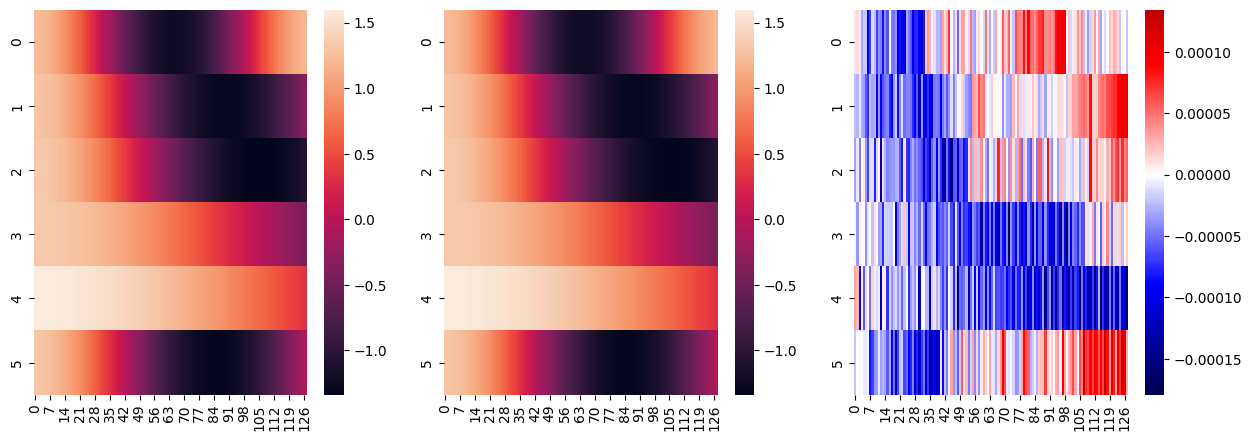

In [281]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.heatmap(core.real)
plt.subplot(1, 3, 2)
sns.heatmap(core_all_dump.real)
plt.subplot(1, 3, 3)
sns.heatmap(core.real - core_all_dump.real, cmap='seismic', center=0)

<Axes: >

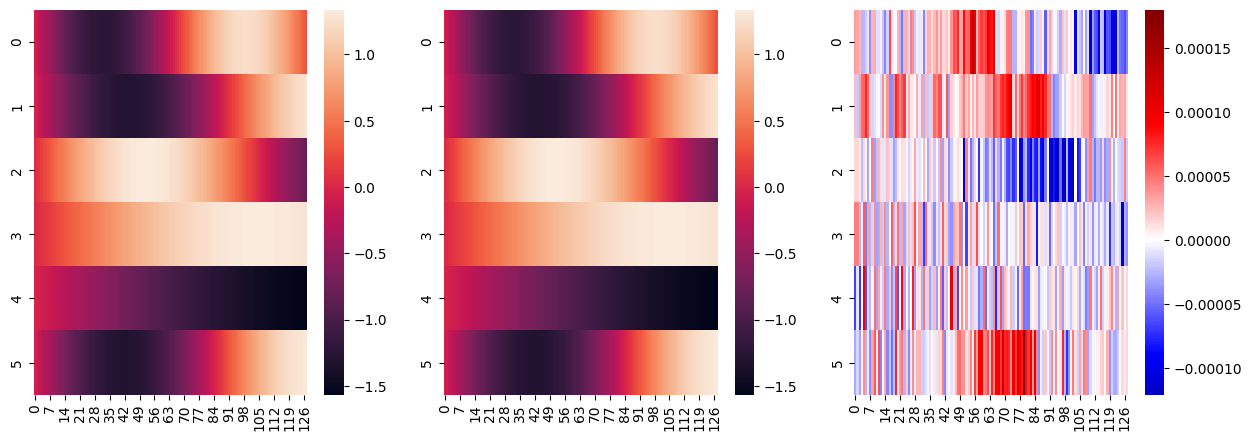

In [282]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.heatmap(core.imag)
plt.subplot(1, 3, 2)
sns.heatmap(core_all_dump.imag)
plt.subplot(1, 3, 3)
sns.heatmap(core.imag - core_all_dump.imag, cmap='seismic', center=0)

In [110]:
from dumps import best_sources_dump, sources_dump, alpha_peaks_sym_dump, delta_peaks_dump
sources_dump = sources_dump[..., 0] + sources_dump[..., 1] * 1j
cy_best_sources = np.empty(best_sources_dump.shape, dtype=np.uint8)
cy_sources_dump = np.empty(sources_dump.shape, dtype=np.complex64)
cy_compute_sources(spectrogram_dump, alpha_peaks_sym_dump, delta_peaks_dump, duet.frequencies_f32, cy_best_sources, cy_sources_dump)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.heatmap(abs(sources_dump[0]))
plt.subplot(1, 3, 2)
sns.heatmap(abs(cy_sources_dump[0]))
plt.subplot(1, 3, 3)
sns.heatmap(abs(sources_dump[0]) - abs(cy_sources_dump[0]), cmap='seismic', center=0)


ImportError: cannot import name 'sources_dump' from 'duet_0000.dump_0012' (/Users/bushj/projects/DUET/duet_0000/dump_0012.py)

(0.0, 15.0)

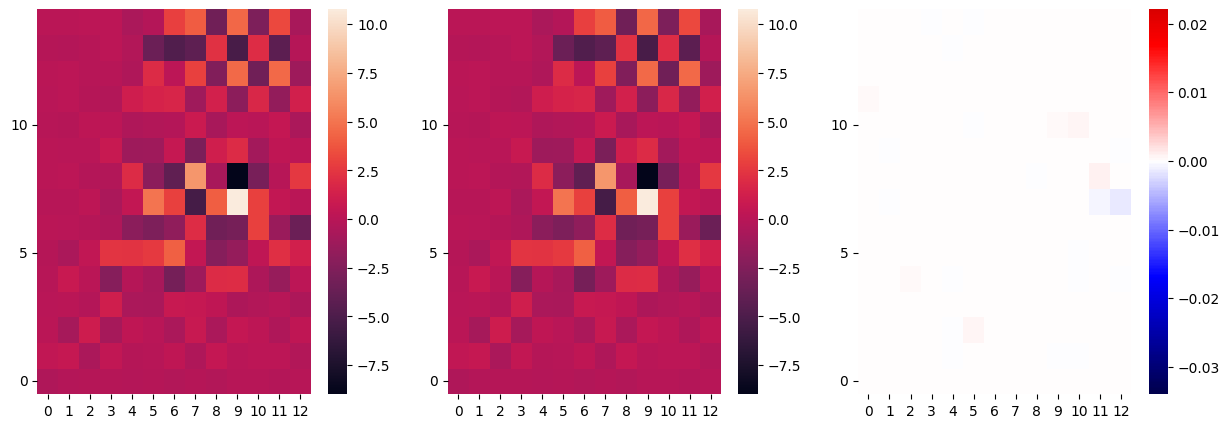

In [289]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.heatmap(sources_dump[0].real)
plt.ylim(0, 15)
plt.subplot(1, 3, 2)
sns.heatmap(cy_sources_dump[0].real)
plt.ylim(0, 15)
plt.subplot(1, 3, 3)
sns.heatmap(sources_dump[0].real / cy_sources_dump[0].real - 1, cmap='seismic', center=0)
plt.ylim(0, 15)


(0.0, 15.0)

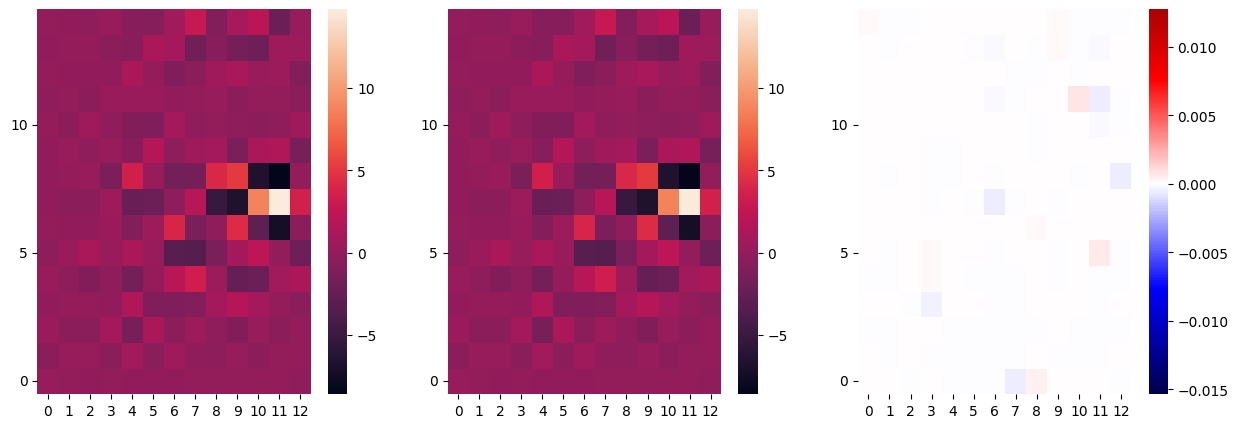

In [290]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.heatmap(sources_dump[0].imag)
plt.ylim(0, 15)
plt.subplot(1, 3, 2)
sns.heatmap(cy_sources_dump[0].imag)
plt.ylim(0, 15)
plt.subplot(1, 3, 3)
sns.heatmap(sources_dump[0].imag / cy_sources_dump[0].imag - 1, cmap='seismic', center=0)
plt.ylim(0, 15)


## Demix

In [111]:
%%cython -c=-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION -c=-O3 -c=-ffast-math
cimport numpy as np
import numpy as np

cdef extern from *:
    """
    #include <complex.h>
    #include <float.h>
    #include <string.h>
    #include <stdint.h>

    static inline float cabsf2(float complex x) {
        // squared cabsf(x), avoids the sqrtf call
        return crealf(x) * crealf(x) + cimagf(x) * cimagf(x);
    }

    static void c_demix(
        const uint8_t* const best,
        const complex float* const sources,
        const int n_sources, const int n_freq, const int n_time,
        complex float* demixed
    ) {
        int n_ft = n_freq * n_time;
        int n_ft1 = (n_freq + 1) * n_time;

        // fill in all values with zeros (includes DC component and masked sources)
        memset(demixed, 0, sizeof(complex float) * n_sources * n_ft1);  // TODO: use DSP memset

        // fill in the rest with the best source
        complex float* out = &demixed[n_time];
        for (int i = 0; i < n_ft; i++) {
            int b = best[i];
            out[b*n_ft1+i] = sources[b*n_ft+i];
        }

        // Alternate implementation (slightly slower):
        // for (int i = 0; i < n_sources; i++) { memset(&demixed[i*n_ft1], 0, sizeof(complex float) * n_time); }
        // for (int i = 0; i < n_sources; i++) {
        //     const complex float* const src = &sources[i*n_ft];
        //     complex float* out = &demixed[i*n_ft1+n_time];
        //     for (int j = 0; j < n_ft; j++) { out[j] = (best[j] == i) * src[j]; }
        // }
   }

    static void c_demix_trans(
        const uint8_t* const best,
        const complex float* const sources,
        const int n_sources, const int n_time, const int n_freq,
        complex float* demixed
    ) {
        int n_tf = n_time * n_freq;
        int n_tf1 = n_time * (n_freq + 1);

        // fill in all with zeros (includes DC component and masked sources)
        memset(demixed, 0, sizeof(complex float) * n_sources * n_tf1);  // TODO: use DSP memset

        complex float* out = &demixed[1];
        for (int i = 0; i < n_tf; i++) {
            int b = best[i];
            int t = i / n_freq; // this will be compiler optimized since n_freq is a power of 2 and a compile-time constant
            out[b*n_tf1+t+i] = sources[b*n_tf+i];
        }
    }

    static void c_demix_full(
        const float complex * const spectrogram, // in, shape (n_channels, n_freq, n_time)
        const float * const alpha, // in, length n_sources
        const float * const delta, // in, length n_sources
        const float * const freqs, // in, length n_freq
        const int n_sources, const int n_freq, const int n_time,
        complex float* demixed, // out, shape (n_sources, n_freq, n_time)
        uint8_t* best           // out, shape (n_freq, n_time)
    ) {
        int n_tf = n_time * n_freq;  // total number of time-frequency bins

        // fill in all demixed values with zeros (masked sources)
        memset(demixed, 0, sizeof(complex float) * n_sources * n_tf);  // TODO: use DSP memset
        complex float* out = &demixed[0];

        const float complex * const spec0 = &spectrogram[0 * n_tf];
        const float complex * const spec1 = &spectrogram[1 * n_tf];

        // Precompute denominators
        float denom[n_sources];  // 1 / (1 + alphas * alphas)
        for (int s = 0; s < n_sources; s++) { denom[s] = 1.0 / (1.0 + alpha[s] * alpha[s]); } // TODO: use DSP division

        for (int f = 0; f < n_freq; f++) {
            // Precompute the core for this frequency
            float freq = freqs[f];
            float complex core[n_sources];
            for (int s = 0; s < n_sources; s++) { core[s] = alpha[s] * cexpf(-I * (delta[s] * freq)); }

            for (int t = 0; t < n_time; t++) {
                complex float spec0_ft = spec0[f*n_time+t];
                complex float spec1_ft = spec1[f*n_time+t];

                float min_score = FLT_MAX;
                uint8_t best_index = 0;
                for (uint8_t s = 0; s < n_sources; s++) {
                    float score = cabsf2(core[s] * spec0_ft - spec1_ft) * denom[s];
                    if (score < min_score) { min_score = score; best_index = s; }
                }

                // Store the best source in the output
                complex float src_val = (core[best_index] * spec1_ft + spec0_ft) * denom[best_index];
                out[best_index*n_tf+f*n_time+t] = src_val;
                best[f*n_time+t] = best_index;  // store the index of the best source
            }
        }
    }
    """
    void c_demix(
        np.uint8_t* best,                       # in, shape (n_freq, n_time), int
        np.complex64_t* sources,                # in, shape (n_sources, n_freq, n_time), complex
        int n_sources, int n_freq, int n_time,
        np.complex64_t* demixed                 # out, shape (n_sources, n_freq+1, n_time), complex
    ) nogil
    void c_demix_trans(
        np.uint8_t* best,                       # in, shape (n_time, n_freq), int
        np.complex64_t* sources,                # in, shape (n_sources, n_time, n_freq), complex
        int n_sources, int n_time, int n_freq,
        np.complex64_t* demixed                 # out, shape (n_sources, n_time, n_freq+1), complex
    ) nogil
    void c_demix_full(
        np.complex64_t* spectrogram,            # in, shape (n_channels, n_freq, n_time), complex
        np.float32_t* alpha,                    # in, length n_sources
        np.float32_t* delta,                    # in, length n_sources
        np.float32_t* freqs,                    # in, length n_freq
        int n_sources, int n_freq, int n_time,
        np.complex64_t* demixed,                # out, shape (n_sources, n_freq, n_time), complex
        np.uint8_t* best                        # out, shape (n_freq, n_time), int
    ) nogil

def cy_demix(
    np.ndarray[np.uint8_t, ndim=2] best,        # in, has shape (n_freq, n_time), int
    np.ndarray[np.complex64_t, ndim=3] sources, # in, has shape (n_sources, n_freq, n_time), complex
    np.ndarray[np.complex64_t, ndim=3] demixed  # out, has shape (n_sources, n_freq+1, n_time), complex
):
    cdef int n_sources = sources.shape[0], n_freq = sources.shape[1], n_time = sources.shape[2]
    cdef np.uint8_t* best_ptr = &best[0, 0]
    cdef np.complex64_t* sources_ptr = &sources[0, 0, 0]
    cdef np.complex64_t* demixed_ptr = &demixed[0, 0, 0]
    with nogil: c_demix(best_ptr, sources_ptr, n_sources, n_freq, n_time, demixed_ptr)

def cy_demix_trans(
    np.ndarray[np.uint8_t, ndim=2] best,        # in, has shape (n_time, n_freq), int
    np.ndarray[np.complex64_t, ndim=3] sources, # in, has shape (n_sources, n_time, n_freq), complex
    np.ndarray[np.complex64_t, ndim=3] demixed  # out, has shape (n_sources, n_time, n_freq+1), complex
):
    cdef int n_sources = sources.shape[0], n_time = sources.shape[1], n_freq = sources.shape[2]
    cdef np.uint8_t* best_ptr = &best[0, 0]
    cdef np.complex64_t* sources_ptr = &sources[0, 0, 0]
    cdef np.complex64_t* demixed_ptr = &demixed[0, 0, 0]
    with nogil: c_demix_trans(best_ptr, sources_ptr, n_sources, n_time, n_freq, demixed_ptr)

def cy_demix_full(
    np.ndarray[np.complex64_t, ndim=3] spectrogram, # in, has shape (n_channels, n_freq, n_time), complex
    np.ndarray[np.float32_t, ndim=1] alpha,        # in, has length n_sources
    np.ndarray[np.float32_t, ndim=1] delta,        # in, has length n_sources
    np.ndarray[np.float32_t, ndim=1] freqs,        # in, has length n_freq
    np.ndarray[np.complex64_t, ndim=3] demixed,    # out, has shape (n_sources, n_freq, n_time), complex
    np.ndarray[np.uint8_t, ndim=2] best            # out, has shape (n_freq, n_time), int
):
    cdef int n_sources = alpha.shape[0], n_freq = spectrogram.shape[1], n_time = spectrogram.shape[2]
    if delta.size != n_sources: raise ValueError("Delta must have the same length as alpha")
    if freqs.size != n_freq: raise ValueError("Frequencies must have the same length as the second dimension of spectrogram")
    if demixed.shape[0] != n_sources or demixed.shape[1] != n_freq or demixed.shape[2] != n_time:
        raise ValueError(f"Demixed must have shape (n_sources, n_freq, n_time) ({demixed.shape[0]}, {demixed.shape[1]}, {demixed.shape[2]})")
    if best.shape[0] != n_freq or best.shape[1] != n_time:
        raise ValueError("Best must have shape (n_freq, n_time)")
    cdef np.complex64_t* spectrogram_ptr = &spectrogram[0, 0, 0]
    cdef np.float32_t* alpha_ptr = &alpha[0]
    cdef np.float32_t* delta_ptr = &delta[0]
    cdef np.float32_t* freqs_ptr = &freqs[0]
    cdef np.complex64_t* demixed_ptr = &demixed[0, 0, 0]
    cdef np.uint8_t* best_ptr = &best[0, 0]
    with nogil: c_demix_full(spectrogram_ptr, alpha_ptr, delta_ptr, freqs_ptr, n_sources, n_freq, n_time, demixed_ptr, best_ptr)

In [126]:
sources_f32 = sources.astype(np.complex64)

cy_atn_peaks = np.ascontiguousarray(atn_peaks, dtype=np.float32)
cy_delay_peaks = np.ascontiguousarray(delay_peaks, dtype=np.float32)

cy_best = np.ascontiguousarray(best, dtype=np.uint8)
cy_sources = np.ascontiguousarray(sources_f32)
cy_demixed = np.empty((sources_f32.shape[0], sources_f32.shape[1] + 1, sources_f32.shape[2]), dtype=np.complex64)
cy_demix(cy_best, cy_sources, cy_demixed)

cy_best_trans = np.ascontiguousarray(best.T, dtype=np.uint8)  # transpose to (n_time, n_freq)
cy_sources_trans = np.ascontiguousarray(sources_f32.transpose(0, 2, 1))  # transpose to (n_sources, n_time, n_freq)
cy_demixed_trans = np.empty((sources_f32.shape[0], sources_f32.shape[2], sources_f32.shape[1] + 1), dtype=np.complex64)
cy_demix_trans(cy_best_trans, cy_sources_trans, cy_demixed_trans)

# full demix was rewritten to avoid the DC component (thus the -1)
cy_best_full = np.empty_like(cy_best)
cy_demixed_full = np.empty((cy_demixed.shape[0], cy_demixed.shape[1] - 1, cy_demixed.shape[2]), dtype=np.complex64)
cy_demix_full(cy_tf, cy_atn_peaks, cy_delay_peaks, duet.frequencies_f32, cy_demixed_full, cy_best_full)

np.allclose(cy_demixed, demixed), np.allclose(cy_demixed_trans, demixed.transpose(0, 2, 1)), np.allclose(cy_demixed_full, cy_demixed[:, 1:, :]), np.equal(cy_best, best).all()

(True, True, True, True)

In [ ]:
%timeit duet._demix(best, sources_f32)
%timeit cy_demix(cy_best, cy_sources, cy_demixed)
%timeit cy_demix_trans(cy_best_trans, cy_sources_trans, cy_demixed_trans)
%timeit cy_demix_full(cy_tf, cy_atn_peaks, cy_delay_peaks, duet.frequencies_f32, cy_demixed_full, cy_best_full)

846 µs ± 61.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
70.8 µs ± 4.31 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
70.7 µs ± 2.56 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
452 µs ± 29.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [150]:
from duet_0000.dump_0012 import demixed_dump, best_dump, alpha_peaks_sym_dump, delta_peaks_dump, spectrogram_dump
spectrogram_dump = spectrogram_dump[..., 0] + spectrogram_dump[..., 1] * 1j
demixed_dump = demixed_dump[..., 0] + demixed_dump[..., 1] * 1j
cy_demixed_full = np.empty((demixed_dump.shape[0], demixed_dump.shape[1], demixed_dump.shape[2]), dtype=np.complex64)
cy_best_full = np.empty((demixed_dump.shape[1], demixed_dump.shape[2]), dtype=np.uint8)
cy_demix_full(spectrogram_dump, alpha_peaks_sym_dump, delta_peaks_dump, duet.frequencies_f32, cy_demixed_full, cy_best_full)


In [151]:
cy_best = np.empty_like(best_dump)
cy_sources = np.empty((alpha_peaks_sym_dump.size, demixed_dump.shape[1], demixed_dump.shape[2]), dtype=np.complex64)
cy_compute_sources(spectrogram_dump, alpha_peaks_sym_dump, delta_peaks_dump, duet.frequencies_f32, cy_best, cy_sources)

<Axes: >

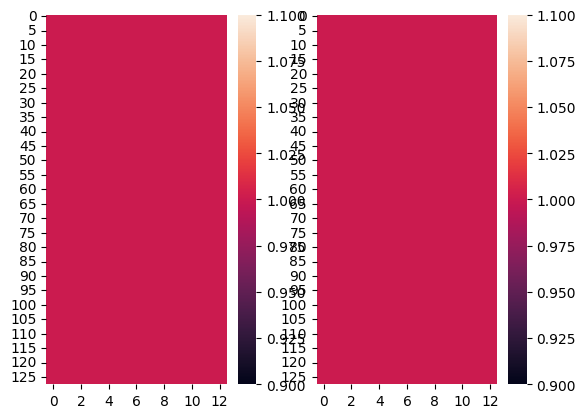

In [152]:
plt.subplot(1, 2, 1)
sns.heatmap(best_dump == cy_best)
plt.subplot(1, 2, 2)
sns.heatmap(cy_best_full == cy_best)

<Axes: >

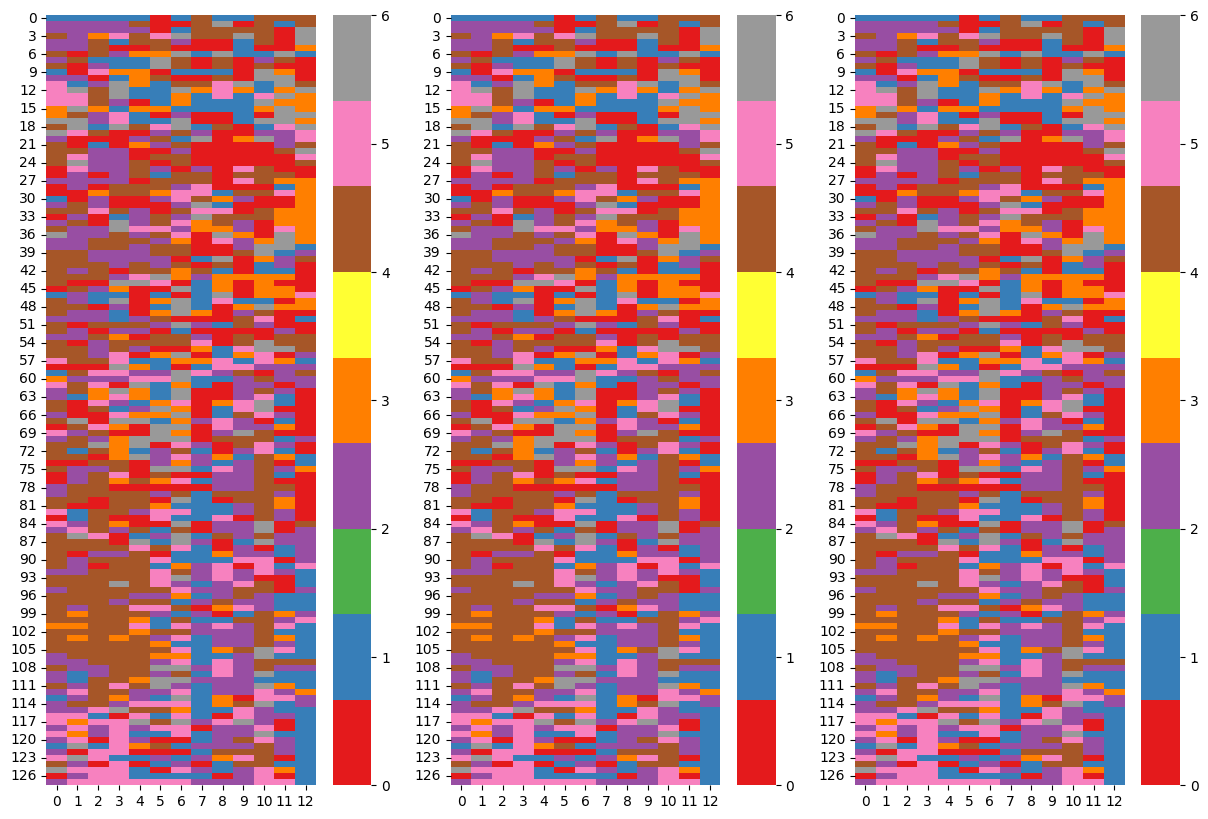

In [154]:
plt.figure(figsize=(20, 10))
# plt.subplot(1, 4, 1)
# sns.heatmap(best_sources_dump, cmap='Set1')
plt.subplot(1, 4, 2)
sns.heatmap(best_dump, cmap='Set1')
plt.subplot(1, 4, 3)
sns.heatmap(cy_best_full, cmap='Set1')
plt.subplot(1, 4, 4)
sns.heatmap(cy_best, cmap='Set1')

<Axes: >

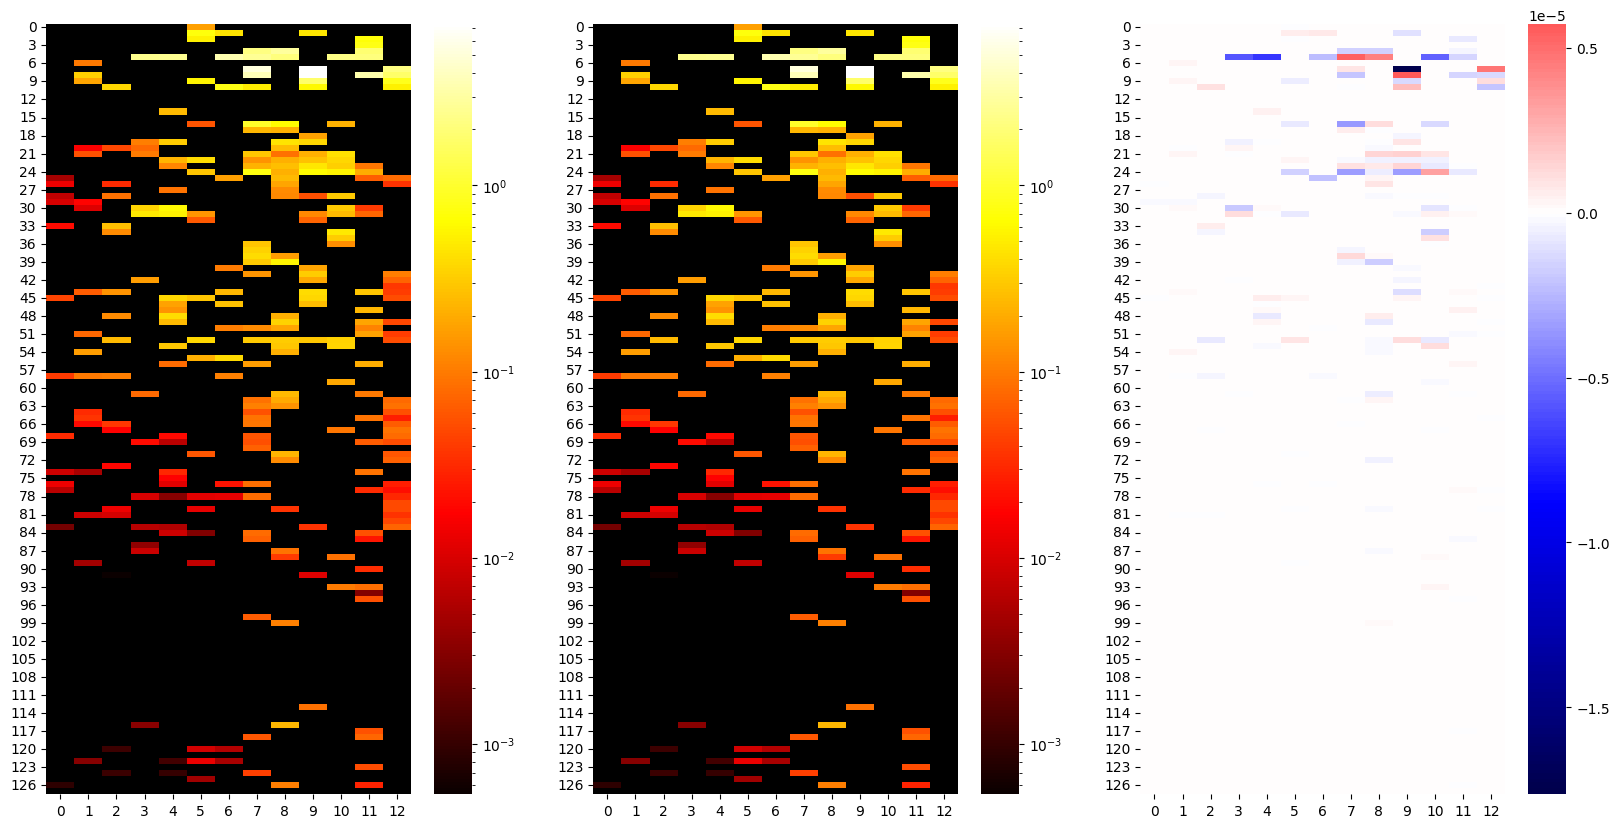

In [156]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.gca().set_facecolor('black')
sns.heatmap(np.abs(cy_demixed_full[0]), cmap='hot', norm=LogNorm())
plt.subplot(1, 3, 2)
plt.gca().set_facecolor('black')
sns.heatmap(np.abs(demixed_dump[0]), cmap='hot', norm=LogNorm())
plt.subplot(1, 3, 3)
sns.heatmap(cy_demixed_full[0].imag - demixed_dump[0].imag, cmap='seismic', center=0)

In [157]:
np.allclose(cy_demixed_full, demixed_dump, atol=6e-5, rtol=6e-5)

True

In [158]:
np.allclose(cy_demixed_full, demixed_dump, atol=3e-6, rtol=3e-6)

True

In [134]:
s16 = [
    0, 1145, 2289, 3435, 4572, 5716, 6853, 7989, 9125, 10255, 11385,
    12508, 13631, 14745, 15859, 16963, 18067, 19165, 20253, 21342, 22417,
    23489, 24553, 25610, 26659, 27703, 28731, 29755, 30773, 31777, 32772,
    33756, 34734, 35697, 36649, 37594, 38523, 39445, 40350, 41247, 42131,
    42998, 43856, 44701, 45528, 46344, 47147, 47931, 48708, 49461, 50205,
    50933, 51646, 52342, 53022, 53686, 54334, 54969, 55579, 56180, 56760,
    57322, 57866, 58394, 58908, 59399, 59871, 60327, 60768, 61184, 61584,
    61969, 62330, 62677, 63000, 63304, 63593, 63858, 64108, 64334, 64545,
    64731, 64903, 65049, 65177, 65289, 65377, 65449, 65501, 65527, 65535,
    65535
]

In [135]:
(np.sin(np.linspace(0, np.pi/2, 91)) * (2**16-1)).round().astype(np.uint16) - s16[:-1]

array([ 0, -1, -2, -5, -1, -4, -3, -2, -4, -3, -5, -3, -6, -3, -5, -1, -3,
       -4, -2, -6, -3, -3, -3, -3, -4, -7, -2, -3, -6, -5, -5, -3, -6, -4,
       -2, -5, -2, -5, -3, -4, -6, -3, -5, -6, -4, -4, -5, -2, -6, -1, -2,
       -3, -4, -3, -3, -3, -3, -7, -2, -6, -5, -4, -2, -2, -6, -4, -2, -2,
       -5, -2, -1, -4, -3, -6, -4, -2, -5, -3, -5, -3, -6, -3, -6, -2, -1,
       -3, -2, -4, -6, -2,  0])

In [136]:
(np.sin(np.linspace(0, np.pi/2, 256+1)) * (2**24-1)).round().astype(np.int32)

array([       0,   102943,   205882,   308814,   411733,   514638,
         617523,   720384,   823219,   926022,  1028791,  1131521,
        1234208,  1336849,  1439440,  1541976,  1644455,  1746871,
        1849222,  1951503,  2053710,  2155840,  2257889,  2359854,
        2461729,  2563511,  2665197,  2766783,  2868264,  2969638,
        3070900,  3172046,  3273072,  3373976,  3474752,  3575398,
        3675909,  3776281,  3876512,  3976596,  4076531,  4176312,
        4275936,  4375399,  4474697,  4573827,  4672785,  4771566,
        4870168,  4968587,  5066819,  5164860,  5262706,  5360354,
        5457801,  5555042,  5652074,  5748893,  5845495,  5941878,
        6038036,  6133968,  6229668,  6325134,  6420362,  6515348,
        6610089,  6704581,  6798821,  6892804,  6986528,  7079989,
        7173184,  7266108,  7358759,  7451133,  7543226,  7635035,
        7726557,  7817788,  7908724,  7999363,  8089701,  8179734,
        8269459,  8358873,  8447972,  8536753,  8625212,  8713

In [137]:
1 / (2**24-1)

5.960464832810452e-08

In [138]:
%%cython -c=-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION -c=-O3 -c=-ffast-math

cimport numpy as np
import numpy as np

cdef extern from *:
    """
const float PI_ = 3.14159265358979323846f; // pi constant (as a float)

#include <stdint.h>
#include <stdbool.h>

const static int32_t __sin_table_24[] = {
              0,   205882,   411733,   617523,   823219,  1028791,
        1234208,  1439440,  1644455,  1849222,  2053710,  2257889,
        2461729,  2665197,  2868264,  3070900,  3273072,  3474752,
        3675909,  3876512,  4076531,  4275936,  4474697,  4672785,
        4870168,  5066819,  5262706,  5457801,  5652074,  5845495,
        6038036,  6229668,  6420362,  6610089,  6798821,  6986528,
        7173184,  7358759,  7543226,  7726557,  7908724,  8089701,
        8269459,  8447972,  8625212,  8801154,  8975770,  9149035,
        9320921,  9491404,  9660458,  9828057,  9994175, 10158789,
       10321873, 10483402, 10643353, 10801700, 10958421, 11113492,
       11266889, 11418589, 11568570, 11716808, 11863282, 12007970,
       12150849, 12291898, 12431096, 12568422, 12703856, 12837376,
       12968963, 13098596, 13226258, 13351927, 13475585, 13597215,
       13716796, 13834312, 13949744, 14063076, 14174290, 14283369,
       14390297, 14495058, 14597637, 14698016, 14796183, 14892121,
       14985816, 15077255, 15166423, 15253307, 15337894, 15420171,
       15500126, 15577746, 15653021, 15725938, 15796487, 15864657,
       15930438, 15993820, 16054794, 16113349, 16169478, 16223172,
       16274423, 16323223, 16369564, 16413441, 16454846, 16493772,
       16530215, 16564168, 16595627, 16624587, 16651043, 16674991,
       16696428, 16715351, 16731756, 16745642, 16757006, 16765847,
       16772162, 16775952, 16777215, 16777215
};
const static int __sin_table_24_size = (sizeof(__sin_table_24) / sizeof(__sin_table_24[0])) - 2; // quarter circle
const static int __sin_table_24_full = __sin_table_24_size * 4; // full circle
const static int __sin_table_24_half = __sin_table_24_size * 2; // half circle
const static float __sin_table_24_scale = 5.960464832810452e-08f; // 1.0 / __sin_table_24[__sin_table_24_size]

static void sincos_fast_24(float radians, float *sine, float *cosine) {
    bool sin_neg = (radians < 0), cos_neg = false;
    if (sin_neg) { radians = -radians; }

    float index = radians * (__sin_table_24_half / PI_); // convert to an "index" in the lookup table
    long whole = (long)index;
    float remain = index - whole;
    if (whole >= __sin_table_24_full) { whole %= __sin_table_24_full; }

    // deal with quadrants
    int_fast16_t y = whole;  // shrink data type since number is always in [0, __sin_table_24_full)
    if (y >= __sin_table_24_half) { y -= __sin_table_24_half; sin_neg = !sin_neg; cos_neg = !cos_neg; }
    if (y >= __sin_table_24_size) {
        y = __sin_table_24_half - y;
        if (remain != 0) { remain = 1-remain; y--; }
        cos_neg = !cos_neg;
    }

    // SIN
    int32_t value = __sin_table_24[y];
    if (remain > 0) { value += (__sin_table_24[y+1] - value) * remain; }
    *sine = (sin_neg ? -value : value) * __sin_table_24_scale;

    // COS
    y = __sin_table_24_size-y;
    value = __sin_table_24[y];
    if (remain > 0) { value += (__sin_table_24[y-1] - value) * remain; }
    *cosine = (cos_neg ? -value : value) * __sin_table_24_scale;
}
    """
    void sincos_fast_24(float radians, float *sine, float *cosine) nogil

def cy_sincos_fast_24(float radians):
    """
    Fast sine and cosine computation using a lookup table.
    The input is in radians, and the output is in the range [-1, 1].
    """
    cdef float sine, cosine
    with nogil: sincos_fast_24(radians, &sine, &cosine)
    return sine, cosine


In [139]:
cy_s, cy_c = np.transpose([cy_sincos_fast_24(x) for x in np.linspace(0, 2*np.pi, 720)])

In [140]:
%timeit [cy_sincos_fast_24(x) for x in np.linspace(0, 2*np.pi, 1000)]

120 µs ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [141]:
%timeit [cy_sincos_fast_24(x) for x in np.linspace(0, 2*np.pi, 1000)]

110 µs ± 1.41 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [142]:
%timeit [cy_sincos_fast_24(x) for x in np.linspace(0, 2*np.pi, 1000)]

113 µs ± 4.94 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [143]:
%timeit [x for x in np.linspace(0, 2*np.pi, 1000)]

33.2 µs ± 1.29 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [144]:
s = np.sin(np.linspace(0, 2*np.pi, 720))
c = np.cos(np.linspace(0, 2*np.pi, 720))

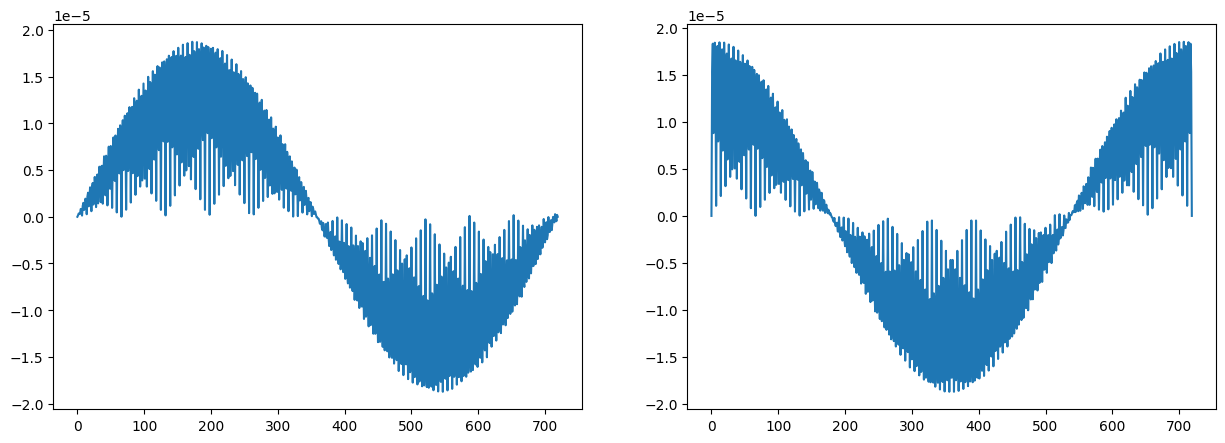

In [145]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(s - cy_s)
plt.subplot(1, 2, 2)
plt.plot(c - cy_c)
plt.show()

In [146]:
(c / cy_c).argmin()

539

In [147]:
c[749:751]

array([], dtype=float64)

In [148]:
cy_c[749:751]

array([], dtype=float64)

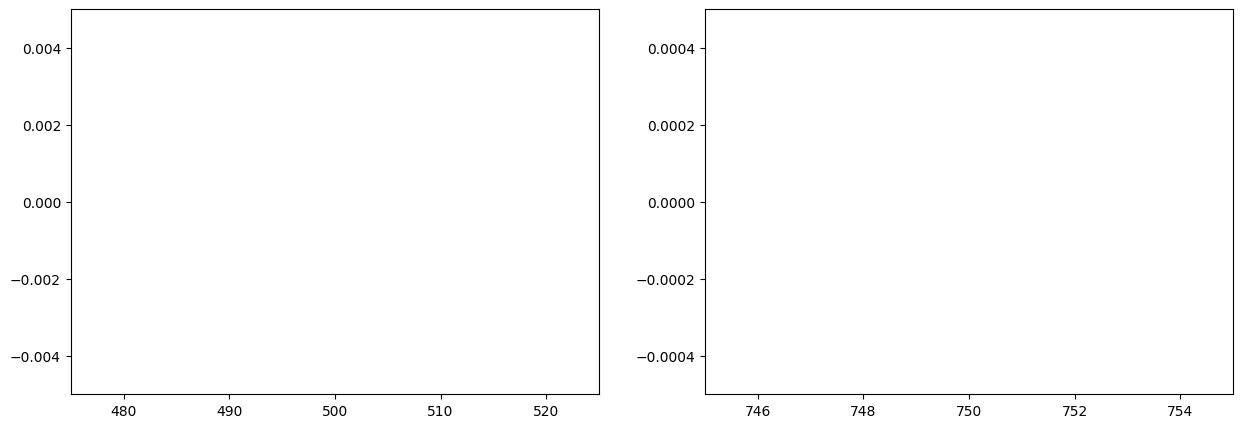

In [149]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(s)
plt.plot(cy_s)
plt.xlim(475, 525)
plt.ylim(-0.005, 0.005)

plt.subplot(1, 2, 2)
plt.plot(c)
plt.plot(cy_c)
plt.xlim(745, 755)
plt.ylim(-0.0005, 0.0005)
plt.show()